In [1]:
import sys
from os.path import isfile
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import random
import logging
from add_spikes import add_spikes
from shift_spectrum import shift_spectrum
from get_redshift import get_redshift
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [2]:
# -- Logging info
logging.basicConfig(filename='modifications.txt', level=logging.INFO,
                    format='%(asctime)s - %(message)s', filemode='w')

In [3]:
def modify(spectrum, sn_name, delay_phase, sn_subtype, sn_maintype, spectral_phase):
    # --Error handling
    if not isinstance(spectrum, np.ndarray):
        raise TypeError(f"Error: Expected 'np.ndarray', got {type(spectrum).__name__}")
    if not isinstance(sn_name, str):
        raise TypeError(f"Error: Expected 'str', got {type(sn_name).__name__}")
    if not isinstance(delay_phase, float):
        raise TypeError(f"Error: Expected 'float', got {type(delay_phase).__name__}")

    # --Copy spectrum and log basic information
    modified_spectrum = spectrum.copy()
    logging.info(f'Object: {sn_name}, phase delay: {delay_phase}')

    # --Prepare modification details
    modification_details = {
        'Object': sn_name,
        'Phase Delay': delay_phase,
        'SN Subtype ID': sn_subtype,
        'SN Maintype ID': sn_maintype,
        'Spectral Phase': spectral_phase,
        'Modification Type': '',
        'Redshift Applied': False,
        'Spikes Added': False
    }

    # --Apply modifications
    modifications = random.randint(0, 3)
    if modifications == 0:
        logging.info('---Modifications: None')
        modification_details['Modification Type'] = 'None'
    else:
        try:
            redshift = get_redshift(sn_name)  # Intentar obtener el redshift
            print(redshift)
        except Exception as e:
            logging.warning(f"Warning: No se encontró redshift para {sn_name}. Detalle: {e}")
            redshift = 0.001  # Valor de redshift alternativo si no se encuentra el original
            logging.info(f'Usando redshift alternativo: {redshift}')
        
        if modifications == 1:
            logging.info('---Modifications: Shift spectra on x axis only')
            modified_spectrum = shift_spectrum(spectrum, redshift)
            modification_details['Modification Type'] = 'Shift Spectrum'
            modification_details['Redshift Applied'] = True

        elif modifications == 2:
            logging.info('---Modifications: Add spikes only')
            modified_spectrum = add_spikes(spectrum, redshift)
            modification_details['Modification Type'] = 'Add Spikes'
            modification_details['Spikes Added'] = True
        elif modifications == 3:
            logging.info('---Modifications: Add spikes first, then shift spectra on x axis')
            modified_spectrum = shift_spectrum(add_spikes(spectrum, redshift), redshift)
            modification_details['Modification Type'] = 'Add Spikes and Shift'
            modification_details['Spikes Added'] = True
            modification_details['Redshift Applied'] = True

    
    return modified_spectrum, modification_details


In [6]:
np.random.seed(3312)
url = "https://github.com/juanserrano90/codelatam/raw/main/Data/data/sn_data.parquet"
df_raw = pd.read_parquet(url)
wavelength = np.array([float(c) for c in df_raw.columns[5:]])
column_names = df_raw.columns.values.tolist()
column_names = np.array(column_names[5:]).astype(float)


In [5]:
data_aumentation_plan = pd.DataFrame(columns=['Type', 'N° of Copys'])

data_aumentation_plan['Type'] = ['IIP', 'IIn', 'Ic-pec', 'Ibn', 'Ib-pec','IIL']
data_aumentation_plan['N° of Copys'] = [41, 153 , 184, 186, 202, 204]

In [11]:
data_aumentation_plan = pd.DataFrame(columns=['Type', 'N° of Copys'])

data_aumentation_plan['Type'] = ['Ia-91T', 'Ia-91bg', 'Ia-pec', 'Iax', 'Ia-csm']
data_aumentation_plan['N° of Copys'] = [79, 213 , 336, 409, 447]

In [12]:
np.random.seed(1)
modified = []
modification_tables = pd.DataFrame()

for i in data_aumentation_plan['Type']:
    print(f"Procesando tipo: {i}")
    
    # Selecciona el subtipo a aumentar
    df_loc = df_raw[df_raw['SN Subtype'] == i]
    
    # Selecciona el número de copias necesarias
    n = data_aumentation_plan[data_aumentation_plan['Type'] == i]['N° of Copys'].values[0]

    # Contador para asegurar el número de copias por subtipo
    count = 0

    # Bucle para asegurar el número de copias deseado
    while count < n:
        # Selecciona una muestra
        df_loc_sampled = df_loc.sample(n=1, replace=True)
        
        # Aplica las modificaciones:
        for index, row in df_loc_sampled.iterrows():
            sn_name = index
            try:
                # Obtiene el valor de 'Spectral Phase'
                delay_phases = row['Spectral Phase']
                sn_subtype = row['SN Subtype ID']
                sn_maintype = row['SN Maintype ID']
                spectral_phase = row['Spectral Phase']
                
                # Intenta obtener la muestra correspondiente de df_raw
                sample = df_raw.loc[(df_raw.index == sn_name)].iloc[:, 5:].values[0]

                # Modifica el espectro y guarda la tabla de modificaciones
                mod_spectrum, mod_table = modify(sample, sn_name,delay_phases, sn_subtype, sn_maintype, spectral_phase)
                modified.append(mod_spectrum)
                
                # Convertir el diccionario a un DataFrame antes de concatenar
                mod_table_df = pd.DataFrame([mod_table])  # Convertir diccionario a DataFrame
                modification_tables = pd.concat([modification_tables, mod_table_df], ignore_index=True)

                # Incrementa el contador solo si se genera una modificación
                count += 1

            except IndexError as e:
                print(f"Error: No se encontró un valor para la supernova {sn_name}. Detalle: {e}")
            except KeyError as e:
                print(f"Error: Columna no encontrada en la fila de {sn_name}. Detalle: {e}")
            except Exception as e:
                print(f"Error inesperado para {sn_name}. Detalle: {e}")




    

Procesando tipo: Ia-91T
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1997br    0.006941
sn1997br    0.006941
Name: redshift, dtype: float64
Error inesperado para sn1997br. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.062573
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.05631713135508915
Wavelength shift: 352.0261051306252 Å
Pixel shift: 48
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 's

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009828358539053805
Wavelength shift: 6.143492562708063 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.02675
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.027213069466685662
Wavelength shift: 170.1029619673768 Å
Pixel shift: 23
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0152
Central wavelength: 6250.781896383187

Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.036699
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.039191927940385826
Wavelength shift: 244.98019365411812 Å
Pixel shift: 33
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1999dq    0.01433
sn1999dq    0.01433
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1997br    0.006941
sn1997br    0.006941
Name: redshift, dtype: float64
Error inesperado para sn1997br. Detalle: operands could not be broadcast together with sh

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009099422032819225
Wavelength shift: 5.687850251029671 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1999dq    0.01433
sn1999dq    0.01433
Name: redshift, dtype: float64
Error inesperado para sn1999dq. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009960556365543368
Wavelength shift: 6.22612654076428 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009496067116754462
Wavelength shift: 5.935784442024848 Å
Pixel shift: 0
Procesando tipo: Ia-91bg
Columnas en el archivo CSV: 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010244991804599843
Wavelength shift: 6.403920930078682 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1991bg    0.003539
sn1991bg    0.003539
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn1991bg    0.003886
sn1991bg    0.003886
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn1991bg    24.289228
sn1991bg    24.289228
Name: redshift, dtype: float64 Å
Error inesperado para sn1991bg. Detalle: cannot convert the series to <class 'int'>
Colu

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010740425320339539
Wavelength shift: 6.713605615183398 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010288722169513986
Wavelength shift: 6.431255827411437 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.01721
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005bl    0.02406
sn2005bl    0.02406
Name: redshift, dtype: float64
Error inesperado para sn2005bl. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cn    0.02349
sn2000cn    0.02349
Name: redshift, dtype: float64
Error inesperado para sn2000cn. Detalle: operand

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2006bz    0.027906
sn2006bz    0.027906
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2006bz    0.030599
sn2006bz    0.030599
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2006bz    191.266916
sn2006bz    191.266916
Name: redshift, dtype: float64 Å
Error inesperado para sn2006bz. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009376388520059642
Wavelength shift: 5.860975961464395 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009129584816028194
Wavelength shift: 5.706704348952386 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1999by    0.002128
sn1999by    0.002128
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn1999by    0.002314
sn1999by    0.002314
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn1999by    14.4649
sn1999by    14.4649
Name: redshift, dtype: float64 Å
Error inesperado para sn1999by. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009792906974678656
Wavelength shift: 6.121332563028599 Å
Pixel shift: 0
Columnas

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005ke    0.00488
sn2005ke    0.00488
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005ke    0.004455
sn2005ke    0.004455
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005ke    27.846508
sn2005ke    27.846508
Name: redshift, dtype: float64 Å
Error inesperado para sn2005ke. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0162
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.006861
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1991bg    0.003539
sn1991bg    0.003539
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn1991bg    0.0038
sn1991bg    0.0038
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn1991bg    23.751299
sn1991bg    23.751299
Name: redshift, dtype: fl

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cn    0.02349
sn2000cn    0.02349
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cn    0.025754
sn2000cn    0.025754
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cn    160.985124
sn2000cn    160.985124
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cn. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Error inesperado para sn2000cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.00718
sn2000cx    0.00718
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    44.880993
sn2000cx    44.880993
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cx. Deta

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.03015963775322282
Wavelength shift: 188.5213176693201 Å
Pixel shift: 25
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.007934
sn2

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.008477
sn2000cx    0.008477
Name: redshift, dtype: float64
Wavelength shift: S

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Error inesperado para sn2000cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.02928170750469302
Wavelength shift: 183.03356716552284 Å
Pi

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06739047275559468
Wavelength shift: 421.2431470893756 Å
Pixel shift: 57
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Error inesperado para sn2000cx. Detalle: operands could not be broadcast together with shape

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0074
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009377155206998937
Wavelength shift: 5.861455200748429 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0074
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.00791032149212918
Wavelength shift: 49.44569437757192 Å
Pixel shift: 6
Columnas en el archivo CSV: ['SN_Name', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Error inesperado para sn2000cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.007568
sn2000cx    0.007568
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    47.306375
sn2000cx    47.306375
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cx. De

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.02745322085498741
Wavelength shift: 171.60409591776465 Å
Pixel shift: 23
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010240936401210382
Wavelength shift: 6.401385985869744 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshi

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0074
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.007720550309256207
Wavelength shift: 48.25947610321431 Å
Pixel shift: 6
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010508350050910317
Wavelength shift: 6.568540425908755 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009683918258524809
Wavelength shift: 6.053206093644147 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0746576845402547
Wavelength shift: 466.66890295011103 Å
Pixel shift: 63
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Columnas en el archivo CSV: ['SN_Na

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.008624
sn2000cx    0.008624
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    53.906715
sn2000cx    53.906715
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.008003
sn2000cx    0.008003
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    50.02363
sn2000cx    50.02363
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.07600111581607079
Wavelength shift: 475.0663988480172 Å
Pixel shift: 6

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.07816623545245595
Wavelength shift: 488.6000894746373 Å
Pixel shift: 66
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06703928404361773
Wavelength shift: 419.04794304633594 Å
Pixel shift: 57
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.7

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.008321
sn2000cx    0.008321
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    52.012377
sn2000cx    52.012377
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Error inesperado para sn2000cx. Detalle: operands could no

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.008358
sn2000cx    0.008358
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    52.241864
sn2000cx    52.241864
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002c

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2002cx    0.024395
sn2002cx    0.024395
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2002cx    152.488714
sn2002cx    152.488714
Name: redshift, dtype: float64 Å
Error inesperado para sn2002cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009614121143477973
Wavelength shift: 6.009577439328694 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.012547
sn2005hk    0.012547
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    78.4265
sn2005hk    78.4265
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009673956075996611
Wavelength shift: 6.046978950624575 Å
Pixel shift: 0
Columnas e

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010264384750583652
Wavelength shift: 6.416043037645995 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.013634
sn2005hk    0.013634
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    85.221903
sn2005hk    85.221903
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Column

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2002cx    0.022151
sn2002cx    0.022151
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2002cx    138.462793
sn2002cx    138.462793
Name: redshift, dtype: float64 Å
Error inesperado para sn2002cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001095947924180375
Wavelength shift: 6.850531443845421 Å
Pixel shift: 0
Colum

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Error inesperado para sn2002cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn19

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.00095486823068164
Wavelength shift: 5.96867304977624 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Col

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.012498
sn2005hk    0.012498
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    78.120555
sn2005hk    78.120555
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Error inesperado para sn2002cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002c

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010446638271251894
Wavelength shift: 6.529965738400509 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: re

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010310708013291773
Wavelength shift: 6.444998698837727 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009924486574029894
Wavelength shift: 6.203580

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.000977161393123748
Wavelength shift: 6.108022745982498 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009416988123601738
Wavelength shift: 5.886353888146522 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', '

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.013734
sn2005hk    0.013734
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    85.845457
sn2005hk    85.845457
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010834158469975343
Wavelength shift: 6.772196162666844 Å
Pixel shift: 0
Column

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'red

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010754890257162065
Wavelength shift: 6.722647331705655 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009956646342224424
Wavelength shift: 6.223682470466631 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009141752015175476
Wavelength shift: 5.714309799768338 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.014223
sn2005hk    0.014223
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    88.903573
sn2005hk    88.903573
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.012
sn2005hk    0.012
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    75.009547
sn2005hk    75.009547
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broad

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Error inesperado para sn2002cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002c

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.013831
sn2005hk    0.013831
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    86.456719
sn2005hk    86.456719
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Error inesperado para sn2002cx. Detalle: operands could not be

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009352809647755298
Wavelength shift: 5.8462373226506825 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.05554
sn2005gj    0.05554
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    347.16635
sn2005gj    347.16635
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009500633303645555
Wavelength shift: 5.9386386658602826 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
S

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010567747653183902
Wavelength shift: 6.605668571606784 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.064788
sn2005gj    0.064788
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    404.974647
sn2005gj    404.974647
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_N

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.055995
sn2005gj    0.055995
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    350.009534
sn2005gj    350.009534
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be b

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001041166194624331
Wavelength shift: 6.508102800483942 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009119844520845794
Wavelength shift: 5.700615902873229 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Columnas en el archivo CSV: ['SN_Name', 'old_na

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.000985994138454285
Wavelength shift: 6.163234310589981 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.066604
sn2005gj    0.066604
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    416.327956
sn2005gj    416.327956
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columna

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', '

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06751220363753735
Wavelength shift: 422.0040602824536 Å
Pixel shift: 57
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.064612
sn2005gj    0.064612
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    403.874214
sn2005gj    403.874214
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
C

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.0636
sn2005gj    0.0636
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    397.552618
sn2005gj    397.552618
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: can

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06600526751434235
Wavelength shift: 412.58453124458043 Å
Pixel shift: 56
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.060997
sn2005gj    0.060997
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    381.276907
sn2005gj    381.276907
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.056073
sn2005gj    0.056073
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    350.502717
sn2005gj    350.502717
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be b

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.063456
sn2005gj    0.063456
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    396.650558
sn2005gj    396.650558
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.059494923171975564
Wavelength shift: 371.88978869009344 Å
Pixel shift: 50

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.060447
sn2005gj    0.060447
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    377.842933
sn2005gj    377.842933
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.066535609938169
Wavelength shift: 415.89958606632 Å
Pixel shift: 56
Colum

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.055638
sn2005gj    0.055638
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    347.779328
sn2005gj    347.779328
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be b

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.058361
sn2005gj    0.058361
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    364.799594
sn2005gj    364.799594
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle:

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06841807582193545
Wavelength shift: 427.6664697331263 Å
Pixel shift: 58
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010818477528121019
Wavelength shift: 6.762394347920719 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
N

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.065489
sn2005gj    0.065489
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    409.359415
sn2005gj    409.359415
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_N

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06813106756962377
Wavelength shift: 425.8724437454639 Å
Pixel shift: 58
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.066461
sn2005gj    0.066461
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    415.432536
sn2005gj    415.432536
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
C

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.057094
sn2005gj    0.057094
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    356.881025
sn2005gj    356.881025
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle:

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.07236131126522331
Wavelength shift: 452.31477445520665 Å
Pixel shift: 61
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006e

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.06744
sn2005gj    0.06744
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    421.552715
sn2005gj    421.552715
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Nam

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06203428555593956
Wavelength shift: 387.76278910813204 Å
Pixel shift: 52
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006e

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.058157
sn2005gj    0.058157
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    363.527028
sn2005gj    363.527028
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk',

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.000904905421267489
Wavelength shift: 5.656366425197821 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.06004
sn2005gj    0.06004
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    375.294491
sn2005gj    375.294491
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'y

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010593584472801045
Wavelength shift: 6.62181860403908 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.055731
sn2005gj    0.055731
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    348.361325
sn2005gj    348.361325
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle:

In [13]:
print(i)

Ia-csm


In [14]:
modification_tables['Modification Type'].value_counts()


None                    549
Add Spikes              396
Shift Spectrum          279
Add Spikes and Shift    260
Name: Modification Type, dtype: int64

In [17]:
modification_tables.to_csv('Modification_Ia_pec.csv', index=False)

In [16]:
if isinstance(modified, list):
    # Extraer el primer array de cada elemento
    extracted_arrays = []
    for item in modified:
        if isinstance(item, tuple):
            extracted_arrays.append(item[0])  # Toma el primer array de la tupla
        elif isinstance(item, np.ndarray):
            extracted_arrays.append(item)  # Toma directamente el array si es un array
        else:
            print(f"Elemento ignorado: {item}, tipo: {type(item)}")
    
    # Convertir los arrays extraídos a un DataFrame
    modified_df = pd.DataFrame(extracted_arrays)
    
    # Exportar a CSV
    modified_df.to_csv('Ia-peculiars-copy.csv', index=False)
    print("Archivo CSV generado exitosamente.")
else:
    print("Error: 'modified' no es una lista.")

Archivo CSV generado exitosamente.


# Leer los df y concadenarlos a la tabla principal

In [9]:
Iapec = pd.read_csv('Ia-peculiars-copy.csv')
II = pd.read_csv('II-copy.csv')

In [10]:
nuevos_nombres = [f'{i}' for i in wavelength]
Iapec.columns = nuevos_nombres
II.columns = nuevos_nombres

In [11]:
#Marcar las copias

Iapec['COPY'] =True
II['COPY'] = True

In [12]:
#Leer las tablas csv :

modification_iapec = pd.read_csv('Modification_Ia_pec.csv')
modification_ii = pd.read_csv('Modification_II.csv')

In [13]:
modification_iapec

,Object,Phase Delay,SN Subtype ID,SN Maintype ID,Spectral Phase,Modification Type,Redshift Applied,Spikes Added
0,sn2006oa,-2.000,1,0,-2.000,Add Spikes and Shift,True,True
1,sn1999cw,24.500,1,0,24.500,Shift Spectrum,True,False
2,sn2001V,21.100,1,0,21.100,Add Spikes,False,True
3,sn2006oa,-3.800,1,0,-3.800,Add Spikes and Shift,True,True
4,sn1997br,23.100,1,0,23.100,Add Spikes,False,True
...,...,...,...,...,...,...,...,...
1479,sn05gj,48.113,3,0,48.113,Add Spikes and Shift,True,True
1480,sn2005gj,63.900,3,0,63.900,Add Spikes,False,True
1481,sn2005gj,51.800,3,0,51.800,None,False,False
1482,sn2002ic,44.100,3,0,44.100,None,False,False


In [14]:
#Concadenar hacia al lado

snIapec = pd.concat([Iapec, modification_iapec], axis=1)
snii = pd.concat([II, modification_ii], axis=1)

In [15]:
df_raw = df_raw.reset_index()
df_raw = df_raw.rename(columns={'SN Name': 'Object'})
df_raw

,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,sn2008ar,Ia-norm,0,Ia,0,-8.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sn2008ar,Ia-norm,0,Ia,0,-7.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sn2008ar,Ia-norm,0,Ia,0,-6.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sn2008ar,Ia-norm,0,Ia,0,-4.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sn2008ar,Ia-norm,0,Ia,0,-3.70,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,sn2007uy,Ib-pec,9,Ib,1,12.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,sn2007uy,Ib-pec,9,Ib,1,45.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,sn2007uy,Ib-pec,9,Ib,1,54.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4999,sn2007uy,Ib-pec,9,Ib,1,75.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Hacer el df por clases

- Revisar que la clase 0 tenga 2387 elementos
- Unir el df 1 con el df1 de las copias
- Elegir los datos del df2 para generar imagenes 

In [16]:
#DF0
df_raw_0 = df_raw[df_raw['SN Subtype ID']== 0]
df_raw_0 

,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,sn2008ar,Ia-norm,0,Ia,0,-8.500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sn2008ar,Ia-norm,0,Ia,0,-7.500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sn2008ar,Ia-norm,0,Ia,0,-6.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sn2008ar,Ia-norm,0,Ia,0,-4.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sn2008ar,Ia-norm,0,Ia,0,-3.700,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,sn1990O,Ia-norm,0,Ia,0,-5.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3993,sn1990O,Ia-norm,0,Ia,0,-0.900,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,sn1990O,Ia-norm,0,Ia,0,18.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3995,sn1990O,Ia-norm,0,Ia,0,19.400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#DF1
df_raw_1 = df_raw[(df_raw['SN Subtype ID']== 1) | (df_raw['SN Subtype ID']== 2) | (df_raw['SN Subtype ID']== 3) |
                  (df_raw['SN Subtype ID']== 4) | (df_raw['SN Subtype ID']== 5)]
df_raw_1 =  pd.concat([df_raw_1, snIapec], axis=0)
df_raw_1

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
18,sn1999ac,Ia-91T,1,Ia,0,-13.900,0.0,0.0,0.0,0.0,...,0.001,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
19,sn1999ac,Ia-91T,1,Ia,0,-12.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
20,sn1999ac,Ia-91T,1,Ia,0,-9.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
21,sn1999ac,Ia-91T,1,Ia,0,-3.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
22,sn1999ac,Ia-91T,1,Ia,0,-2.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,sn05gj,NaN,3,NaN,0,48.113,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,48.113,Add Spikes and Shift,True,True
1480,sn2005gj,NaN,3,NaN,0,63.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,63.900,Add Spikes,False,True
1481,sn2005gj,NaN,3,NaN,0,51.800,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,51.800,None,False,False
1482,sn2002ic,NaN,3,NaN,0,44.100,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,44.100,None,False,False


In [18]:
#Muestrame todo en los que el spectral phase sea nan

df_raw_1["Spectral Phase"] = df_raw_1["Spectral Phase"].fillna(df_raw_1["Phase Delay"])
df_raw_1

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
18,sn1999ac,Ia-91T,1,Ia,0,-13.900,0.0,0.0,0.0,0.0,...,0.001,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
19,sn1999ac,Ia-91T,1,Ia,0,-12.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
20,sn1999ac,Ia-91T,1,Ia,0,-9.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
21,sn1999ac,Ia-91T,1,Ia,0,-3.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
22,sn1999ac,Ia-91T,1,Ia,0,-2.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,sn05gj,NaN,3,NaN,0,48.113,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,48.113,Add Spikes and Shift,True,True
1480,sn2005gj,NaN,3,NaN,0,63.900,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,63.900,Add Spikes,False,True
1481,sn2005gj,NaN,3,NaN,0,51.800,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,51.800,None,False,False
1482,sn2002ic,NaN,3,NaN,0,44.100,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,44.100,None,False,False


In [19]:
#DF2

#Elegir 217 de cada clase que tiene exceso
df_raw_8 = df_raw[df_raw['SN Subtype ID']==8].sample(n=217)
df_raw_11 = df_raw[df_raw['SN Subtype ID']==11].sample(n=217)
df_raw_6 = df_raw[df_raw['SN Subtype ID']==6].sample(n=217)
df_raw_10 = df_raw[df_raw['SN Subtype ID']==10].sample(n=217)
df_raw_16 = df_raw[df_raw['SN Subtype ID']==16].sample(n=217)

#Agregar las clases que faltan sin seleccionar
df_raw_13 = df_raw[df_raw['SN Subtype ID']==13]
df_raw_15 = df_raw[df_raw['SN Subtype ID']==15]
df_raw_12 = df_raw[df_raw['SN Subtype ID']==12]
df_raw_7 = df_raw[df_raw['SN Subtype ID']==7]
df_raw_9 = df_raw[df_raw['SN Subtype ID']==9]
df_raw_14 = df_raw[df_raw['SN Subtype ID']==14]


#Concadenar los df incluyendo el de las copias
II_completo = pd.concat([df_raw_8, df_raw_11, df_raw_6, df_raw_10, df_raw_16, 
                        df_raw_13, df_raw_15, df_raw_12, df_raw_7, df_raw_9, df_raw_14, 
                        snii], axis=0)

In [20]:
II_completo

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
1250,sn2003bg,IIb,8,Ib,1,20.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4715,sn2009mg,IIb,8,Ib,1,23.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4189,sn1993J,IIb,8,Ib,1,-10.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4236,sn1993J,IIb,8,Ib,1,188.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4255,sn1993J,IIb,8,Ib,1,452.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,sn1980K,NaN,14,NaN,3,44.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,44.0,None,False,False
966,sn1980K,NaN,14,NaN,3,66.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,66.0,None,False,False
967,sn1980K,NaN,14,NaN,3,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,12.0,None,False,False
968,sn1980K,NaN,14,NaN,3,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,9.0,None,False,False


In [21]:
#Concaderas todos

main = pd.concat([df_raw_0, df_raw_1, II_completo], axis=0)
main = main.reset_index(drop=True)

In [22]:
main_wavelenght = main.iloc[:, 6:1030]
main_wavelenght 

,2501.69,2505.08,2508.48,2511.87,2515.28,2518.69,2522.1,2525.51,2528.94,2532.36,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Asegurarse de que todas las columnas tienen nombres de tipo string
#scalings ={}

main_wavelenght.columns = main_wavelenght.columns.astype(str)

# Ahora puedes aplicar el escalado
#scalings['minmax'] = minmax_scaler.fit_transform(main_wavelenght )

# Convertir a DataFrame para mantener las columnas originales
#main_wavelength_scaled = pd.DataFrame(scalings['minmax'], columns=main_wavelenght .columns)

#main_wavelength_scaled

In [24]:
main

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
0,sn2008ar,Ia-norm,0,Ia,0,-8.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,sn2008ar,Ia-norm,0,Ia,0,-7.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,sn2008ar,Ia-norm,0,Ia,0,-6.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,sn2008ar,Ia-norm,0,Ia,0,-4.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,sn2008ar,Ia-norm,0,Ia,0,-3.7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,sn1980K,NaN,14,NaN,3,44.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,44.0,None,False,False
7155,sn1980K,NaN,14,NaN,3,66.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,66.0,None,False,False
7156,sn1980K,NaN,14,NaN,3,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,12.0,None,False,False
7157,sn1980K,NaN,14,NaN,3,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,9.0,None,False,False


In [25]:
# Hacerles el nombre
main['Name'] = main['Object'] + '_' + main['SN Subtype ID'].astype(str) + '_' + \
               main['SN Maintype ID'].astype(str) + '_' + main['Spectral Phase'].astype(str) + '_' + \
               main.index.astype(str)

# Agregar "COPY" si la columna 'copy' es True
main['Name'] = main.apply(lambda row: row['Name'] + '_COPY' if row['COPY'] ==True else row['Name'], axis=1)

# Agregar la extensión ".png" al final de la cadena
main['Name'] = main['Name'] + '.png'

# Ver el resultado
print(main[['Name']])

                                 Name
0             sn2008ar_0_0_-8.5_0.png
1             sn2008ar_0_0_-7.5_1.png
2             sn2008ar_0_0_-6.6_2.png
3             sn2008ar_0_0_-4.6_3.png
4             sn2008ar_0_0_-3.7_4.png
...                               ...
7154  sn1980K_14_3_44.0_7154_COPY.png
7155  sn1980K_14_3_66.0_7155_COPY.png
7156  sn1980K_14_3_12.0_7156_COPY.png
7157   sn1980K_14_3_9.0_7157_COPY.png
7158  sn1979C_14_3_12.9_7158_COPY.png

[7159 rows x 1 columns]


In [26]:
main_wavelenght_t = main_wavelenght.T


In [27]:
main_wavelenght_t.columns = main['Name']
main_wavelenght_t

Name,sn2008ar_0_0_-8.5_0.png,sn2008ar_0_0_-7.5_1.png,sn2008ar_0_0_-6.6_2.png,sn2008ar_0_0_-4.6_3.png,sn2008ar_0_0_-3.7_4.png,sn2008ar_0_0_-2.7_5.png,sn2008ar_0_0_-1.7_6.png,sn2008ar_0_0_-0.7_7.png,sn2008ar_0_0_1.2_8.png,sn2008ar_0_0_3.1_9.png,...,sn1980K_14_3_41.0_7149_COPY.png,sn1980K_14_3_11.0_7150_COPY.png,sn1980K_14_3_11.0_7151_COPY.png,sn1980K_14_3_7.0_7152_COPY.png,sn1980K_14_3_12.0_7153_COPY.png,sn1980K_14_3_44.0_7154_COPY.png,sn1980K_14_3_66.0_7155_COPY.png,sn1980K_14_3_12.0_7156_COPY.png,sn1980K_14_3_9.0_7157_COPY.png,sn1979C_14_3_12.9_7158_COPY.png
2501.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2505.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2508.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2511.87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2515.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9939.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9952.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9966.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9979.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
cd ..


/Users/valentina/codelatam/DataPreparation


In [29]:
cd ..

/Users/valentina/codelatam


In [30]:
ls

Data/            DataPreparation/ README.md        Training/


In [31]:
cd Data

/Users/valentina/codelatam/Data


In [32]:
mkdir augmented_images_v2

In [33]:
cd augmented_images_v2

/Users/valentina/codelatam/Data/augmented_images_v2


In [36]:
mkdir 2

In [37]:
ls


0/ 1/ 2/


In [38]:
for i in range(0, len(main_wavelenght_t.columns)):
    # Definir el DPI y el tamaño de la figura
    my_dpi = 100
    print(i)
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(2.65, 2.65), dpi=my_dpi)
    
    # Graficar la columna de datos
    ax.plot(wavelength, main_wavelenght_t.iloc[:, i].values, lw=1, ls='-', color='k', alpha=1)
    
    # Configurar los ejes y la apariencia
    ax.axis('off')
    ax.set_xlim(2500, 10000)
    # ax.set_ylim(0, 1)  # Descomentarlo si es necesario
    ax.set_box_aspect(1)
    
    # Extraer el primer número después del primer guion bajo en el nombre de la columna
    first_num = int(main_wavelenght_t.columns[i].split('_')[1])
    
    # Determinar la carpeta de destino según el valor de first_num
    if first_num == 0:
        target_folder = '0'
    elif 1 <= first_num <= 5:
        target_folder = '1'
    else:
        target_folder = '2'
    
    # Guardar la imagen con el nombre de la columna en la carpeta correspondiente
    file_path = os.path.join(target_folder, f'{main_wavelenght_t.columns[i]}')
    plt.savefig(file_path, bbox_inches='tight', dpi=my_dpi)

    # Cerrar la figura después de guardar
    plt.close()
    
    print(f'Imagen guardada en {file_path}')

0
Imagen guardada en 0/sn2008ar_0_0_-8.5_0.png
1
Imagen guardada en 0/sn2008ar_0_0_-7.5_1.png
2
Imagen guardada en 0/sn2008ar_0_0_-6.6_2.png
3
Imagen guardada en 0/sn2008ar_0_0_-4.6_3.png
4
Imagen guardada en 0/sn2008ar_0_0_-3.7_4.png
5
Imagen guardada en 0/sn2008ar_0_0_-2.7_5.png
6
Imagen guardada en 0/sn2008ar_0_0_-1.7_6.png
7
Imagen guardada en 0/sn2008ar_0_0_-0.7_7.png
8
Imagen guardada en 0/sn2008ar_0_0_1.2_8.png
9
Imagen guardada en 0/sn2008ar_0_0_3.1_9.png
10
Imagen guardada en 0/sn2008ar_0_0_4.1_10.png
11
Imagen guardada en 0/sn2008ar_0_0_5.0_11.png
12
Imagen guardada en 0/sn2008ar_0_0_7.2_12.png
13
Imagen guardada en 0/sn2008ar_0_0_22.6_13.png
14
Imagen guardada en 0/sn2008ar_0_0_25.7_14.png
15
Imagen guardada en 0/sn2008ar_0_0_28.4_15.png
16
Imagen guardada en 0/sn2008ar_0_0_55.6_16.png
17
Imagen guardada en 0/sn2008ar_0_0_105.1_17.png
18
Imagen guardada en 0/sn1998dk_0_0_10.2_18.png
19
Imagen guardada en 0/sn1998dk_0_0_11.1_19.png
20
Imagen guardada en 0/sn1998dk_0_0_13.1_20

Imagen guardada en 0/sn2001ay_0_0_7.2_175.png
176
Imagen guardada en 0/sn2001ay_0_0_7.8_176.png
177
Imagen guardada en 0/sn2001ay_0_0_9.0_177.png
178
Imagen guardada en 0/sn2001ay_0_0_16.5_178.png
179
Imagen guardada en 0/sn2001ay_0_0_22.6_179.png
180
Imagen guardada en 0/sn2001ay_0_0_23.3_180.png
181
Imagen guardada en 0/sn2001ay_0_0_29.4_181.png
182
Imagen guardada en 0/sn2001ay_0_0_29.5_182.png
183
Imagen guardada en 0/sn2001ay_0_0_30.4_183.png
184
Imagen guardada en 0/sn2001ay_0_0_31.4_184.png
185
Imagen guardada en 0/sn2001ay_0_0_31.4_185.png
186
Imagen guardada en 0/sn2001ay_0_0_36.3_186.png
187
Imagen guardada en 0/sn2001ay_0_0_54.6_187.png
188
Imagen guardada en 0/sn2001ay_0_0_54.7_188.png
189
Imagen guardada en 0/sn06cq_0_0_1.914_189.png
190
Imagen guardada en 0/sn2001bg_0_0_4.2_190.png
191
Imagen guardada en 0/sn2001bg_0_0_5.1_191.png
192
Imagen guardada en 0/sn2001bg_0_0_10.0_192.png
193
Imagen guardada en 0/sn2001bg_0_0_14.0_193.png
194
Imagen guardada en 0/sn2001bg_0_0_19.

Imagen guardada en 0/sn1991M_0_0_27.5_342.png
343
Imagen guardada en 0/sn1991M_0_0_80.0_343.png
344
Imagen guardada en 0/sn1991M_0_0_111.8_344.png
345
Imagen guardada en 0/sn07af_0_0_-1.209_345.png
346
Imagen guardada en 0/sn07af_0_0_3.852_346.png
347
Imagen guardada en 0/sn07af_0_0_26.491_347.png
348
Imagen guardada en 0/sn07af_0_0_91.057_348.png
349
Imagen guardada en 0/sn07af_0_0_113.823_349.png
350
Imagen guardada en 0/sn07af_0_0_121.788_350.png
351
Imagen guardada en 0/sn2007af_0_0_-5.6_351.png
352
Imagen guardada en 0/sn2007af_0_0_-4.6_352.png
353
Imagen guardada en 0/sn2007af_0_0_-3.6_353.png
354
Imagen guardada en 0/sn2007af_0_0_-2.6_354.png
355
Imagen guardada en 0/sn2007af_0_0_-1.6_355.png
356
Imagen guardada en 0/sn2007af_0_0_-0.6_356.png
357
Imagen guardada en 0/sn2007af_0_0_0.3_357.png
358
Imagen guardada en 0/sn2007af_0_0_2.3_358.png
359
Imagen guardada en 0/sn2007af_0_0_3.3_359.png
360
Imagen guardada en 0/sn2007af_0_0_4.3_360.png
361
Imagen guardada en 0/sn2007af_0_0_5.

Imagen guardada en 0/sn2003cg_0_0_25.9_518.png
519
Imagen guardada en 0/sn2003cg_0_0_26.7_519.png
520
Imagen guardada en 0/sn2003cg_0_0_28.0_520.png
521
Imagen guardada en 0/sn2003cg_0_0_37.8_521.png
522
Imagen guardada en 0/sn2003cg_0_0_42.9_522.png
523
Imagen guardada en 0/sn2003cg_0_0_51.9_523.png
524
Imagen guardada en 0/sn2003cg_0_0_382.6_524.png
525
Imagen guardada en 0/sn1996ab_0_0_1.3_525.png
526
Imagen guardada en 0/sn1998aq_0_0_-9.9_526.png
527
Imagen guardada en 0/sn1998aq_0_0_-8.9_527.png
528
Imagen guardada en 0/sn1998aq_0_0_-0.9_528.png
529
Imagen guardada en 0/sn1998aq_0_0_0.0_529.png
530
Imagen guardada en 0/sn1998aq_0_0_1.0_530.png
531
Imagen guardada en 0/sn1998aq_0_0_2.0_531.png
532
Imagen guardada en 0/sn1998aq_0_0_3.0_532.png
533
Imagen guardada en 0/sn1998aq_0_0_4.0_533.png
534
Imagen guardada en 0/sn1998aq_0_0_5.0_534.png
535
Imagen guardada en 0/sn1998aq_0_0_6.0_535.png
536
Imagen guardada en 0/sn1998aq_0_0_17.9_536.png
537
Imagen guardada en 0/sn1998aq_0_0_19.9

Imagen guardada en 0/sn2003kf_0_0_-5.4_686.png
687
Imagen guardada en 0/sn2003kf_0_0_-3.4_687.png
688
Imagen guardada en 0/sn2003kf_0_0_8.5_688.png
689
Imagen guardada en 0/sn2003kf_0_0_10.4_689.png
690
Imagen guardada en 0/sn2003kf_0_0_13.4_690.png
691
Imagen guardada en 0/sn2003kf_0_0_14.4_691.png
692
Imagen guardada en 0/sn2003kf_0_0_15.4_692.png
693
Imagen guardada en 0/sn2003kf_0_0_17.4_693.png
694
Imagen guardada en 0/sn2003kf_0_0_18.4_694.png
695
Imagen guardada en 0/sn2003kf_0_0_19.4_695.png
696
Imagen guardada en 0/sn2003kf_0_0_20.3_696.png
697
Imagen guardada en 0/sn2003kf_0_0_21.3_697.png
698
Imagen guardada en 0/sn2003kf_0_0_25.4_698.png
699
Imagen guardada en 0/sn2003kf_0_0_40.1_699.png
700
Imagen guardada en 0/sn2003kf_0_0_41.2_700.png
701
Imagen guardada en 0/sn2003kf_0_0_41.1_701.png
702
Imagen guardada en 0/sn2003kf_0_0_42.1_702.png
703
Imagen guardada en 0/sn2003kf_0_0_53.1_703.png
704
Imagen guardada en 0/sn2003kf_0_0_67.9_704.png
705
Imagen guardada en 0/sn2003kf_0_

Imagen guardada en 0/sn2004at_0_0_1.2_848.png
849
Imagen guardada en 0/sn2004at_0_0_2.2_849.png
850
Imagen guardada en 0/sn2004at_0_0_17.8_850.png
851
Imagen guardada en 0/sn2004at_0_0_29.6_851.png
852
Imagen guardada en 0/sn1998co_0_0_0.0_852.png
853
Imagen guardada en 0/sn1998co_0_0_1.0_853.png
854
Imagen guardada en 0/sn1998co_0_0_3.9_854.png
855
Imagen guardada en 0/sn1998co_0_0_6.9_855.png
856
Imagen guardada en 0/sn1998co_0_0_22.5_856.png
857
Imagen guardada en 0/sn1998co_0_0_24.6_857.png
858
Imagen guardada en 0/sn1998co_0_0_28.4_858.png
859
Imagen guardada en 0/sn1981B_0_0_-1.5_859.png
860
Imagen guardada en 0/sn1981B_0_0_15.4_860.png
861
Imagen guardada en 0/sn1981B_0_0_18.3_861.png
862
Imagen guardada en 0/sn1981B_0_0_22.3_862.png
863
Imagen guardada en 0/sn1981B_0_0_26.3_863.png
864
Imagen guardada en 0/sn1981B_0_0_33.2_864.png
865
Imagen guardada en 0/sn1981B_0_0_92.9_865.png
866
Imagen guardada en 0/sn1981B_0_0_113.7_866.png
867
Imagen guardada en 0/sn1981B_0_0_266.8_867.p

Imagen guardada en 0/sn2000E_0_0_-3.4_1014.png
1015
Imagen guardada en 0/sn2000E_0_0_-2.3_1015.png
1016
Imagen guardada en 0/sn2000E_0_0_7.5_1016.png
1017
Imagen guardada en 0/sn2000E_0_0_117.6_1017.png
1018
Imagen guardada en 0/sn2000E_0_0_119.7_1018.png
1019
Imagen guardada en 0/sn2000E_0_0_120.3_1019.png
1020
Imagen guardada en 0/sn02er_0_0_-11.3_1020.png
1021
Imagen guardada en 0/sn02er_0_0_-9.4_1021.png
1022
Imagen guardada en 0/sn02er_0_0_-8.4_1022.png
1023
Imagen guardada en 0/sn02er_0_0_-7.4_1023.png
1024
Imagen guardada en 0/sn02er_0_0_-6.4_1024.png
1025
Imagen guardada en 0/sn02er_0_0_-5.4_1025.png
1026
Imagen guardada en 0/sn02er_0_0_-4.4_1026.png
1027
Imagen guardada en 0/sn02er_0_0_-3.5_1027.png
1028
Imagen guardada en 0/sn02er_0_0_-2.5_1028.png
1029
Imagen guardada en 0/sn02er_0_0_-1.5_1029.png
1030
Imagen guardada en 0/sn02er_0_0_-0.5_1030.png
1031
Imagen guardada en 0/sn02er_0_0_1.5_1031.png
1032
Imagen guardada en 0/sn02er_0_0_3.4_1032.png
1033
Imagen guardada en 0/sn0

Imagen guardada en 0/sn94ae_0_0_64.0_1174.png
1175
Imagen guardada en 0/sn94ae_0_0_70.0_1175.png
1176
Imagen guardada en 0/sn94ae_0_0_87.8_1176.png
1177
Imagen guardada en 0/sn94ae_0_0_123.6_1177.png
1178
Imagen guardada en 0/sn94ae_0_0_153.4_1178.png
1179
Imagen guardada en 0/sn94ae_0_0_367.7_1179.png
1180
Imagen guardada en 0/sn2006cq_0_0_-3.3_1180.png
1181
Imagen guardada en 0/sn05de_0_0_-0.748_1181.png
1182
Imagen guardada en 0/sn05de_0_0_10.097_1182.png
1183
Imagen guardada en 0/sn05de_0_0_25.745_1183.png
1184
Imagen guardada en 0/sn05de_0_0_40.49_1184.png
1185
Imagen guardada en 0/sn2007au_0_0_-5.6_1185.png
1186
Imagen guardada en 0/sn2007au_0_0_-4.7_1186.png
1187
Imagen guardada en 0/sn2007au_0_0_-3.8_1187.png
1188
Imagen guardada en 0/sn2007au_0_0_1.1_1188.png
1189
Imagen guardada en 0/sn06ef_0_0_3.197_1189.png
1190
Imagen guardada en 0/sn06ef_0_0_28.707_1190.png
1191
Imagen guardada en 0/sn06ef_0_0_34.559_1191.png
1192
Imagen guardada en 0/sn1998V_0_0_0.3_1192.png
1193
Imagen 

Imagen guardada en 0/sn2006S_0_0_-5.5_1332.png
1333
Imagen guardada en 0/sn2006S_0_0_-4.6_1333.png
1334
Imagen guardada en 0/sn2006S_0_0_-2.6_1334.png
1335
Imagen guardada en 0/sn2006S_0_0_-0.7_1335.png
1336
Imagen guardada en 0/sn2006S_0_0_0.2_1336.png
1337
Imagen guardada en 0/sn2006S_0_0_1.2_1337.png
1338
Imagen guardada en 0/sn2006S_0_0_3.2_1338.png
1339
Imagen guardada en 0/sn2006S_0_0_4.1_1339.png
1340
Imagen guardada en 0/sn2006S_0_0_20.5_1340.png
1341
Imagen guardada en 0/sn1996bo_0_0_3.3_1341.png
1342
Imagen guardada en 0/sn1996bo_0_0_5.2_1342.png
1343
Imagen guardada en 0/sn1996bo_0_0_7.1_1343.png
1344
Imagen guardada en 0/sn1996bo_0_0_9.2_1344.png
1345
Imagen guardada en 0/sn1996bo_0_0_11.1_1345.png
1346
Imagen guardada en 0/sn2001gc_0_0_-8.5_1346.png
1347
Imagen guardada en 0/sn2001gc_0_0_3.4_1347.png
1348
Imagen guardada en 0/sn2001gc_0_0_4.4_1348.png
1349
Imagen guardada en 0/sn2001gc_0_0_5.3_1349.png
1350
Imagen guardada en 0/sn2001gc_0_0_7.3_1350.png
1351
Imagen guardad

Imagen guardada en 0/sn2003du_0_0_-8.1_1501.png
1502
Imagen guardada en 0/sn2003du_0_0_-7.2_1502.png
1503
Imagen guardada en 0/sn2003du_0_0_-6.1_1503.png
1504
Imagen guardada en 0/sn2003du_0_0_-4.2_1504.png
1505
Imagen guardada en 0/sn2003du_0_0_-2.2_1505.png
1506
Imagen guardada en 0/sn2003du_0_0_-1.8_1506.png
1507
Imagen guardada en 0/sn2003du_0_0_-1.3_1507.png
1508
Imagen guardada en 0/sn2003du_0_0_-0.3_1508.png
1509
Imagen guardada en 0/sn2003du_0_0_0.9_1509.png
1510
Imagen guardada en 0/sn2003du_0_0_1.1_1510.png
1511
Imagen guardada en 0/sn2003du_0_0_2.1_1511.png
1512
Imagen guardada en 0/sn2003du_0_0_2.9_1512.png
1513
Imagen guardada en 0/sn2003du_0_0_4.0_1513.png
1514
Imagen guardada en 0/sn2003du_0_0_6.9_1514.png
1515
Imagen guardada en 0/sn2003du_0_0_7.9_1515.png
1516
Imagen guardada en 0/sn2003du_0_0_8.8_1516.png
1517
Imagen guardada en 0/sn2003du_0_0_9.8_1517.png
1518
Imagen guardada en 0/sn2003du_0_0_12.7_1518.png
1519
Imagen guardada en 0/sn2003du_0_0_16.0_1519.png
1520
Im

Imagen guardada en 0/sn2007le_0_0_12.4_1660.png
1661
Imagen guardada en 0/sn2007le_0_0_13.4_1661.png
1662
Imagen guardada en 0/sn2007le_0_0_14.4_1662.png
1663
Imagen guardada en 0/sn2007le_0_0_15.4_1663.png
1664
Imagen guardada en 0/sn2007le_0_0_16.4_1664.png
1665
Imagen guardada en 0/sn2007le_0_0_17.4_1665.png
1666
Imagen guardada en 0/sn2007le_0_0_18.3_1666.png
1667
Imagen guardada en 0/sn2007le_0_0_19.3_1667.png
1668
Imagen guardada en 0/sn2007le_0_0_20.3_1668.png
1669
Imagen guardada en 0/sn2007le_0_0_21.3_1669.png
1670
Imagen guardada en 0/sn2007le_0_0_39.2_1670.png
1671
Imagen guardada en 0/sn2007le_0_0_40.1_1671.png
1672
Imagen guardada en 0/sn2007le_0_0_48.2_1672.png
1673
Imagen guardada en 0/sn2007le_0_0_50.1_1673.png
1674
Imagen guardada en 0/sn2007le_0_0_53.1_1674.png
1675
Imagen guardada en 0/sn2007le_0_0_67.0_1675.png
1676
Imagen guardada en 0/sn2007le_0_0_77.9_1676.png
1677
Imagen guardada en 0/sn07fs_0_0_5.029_1677.png
1678
Imagen guardada en 0/sn07fs_0_0_22.667_1678.png

Imagen guardada en 0/sn94S_0_0_1.525_1817.png
1818
Imagen guardada en 0/sn05be_0_0_10.957_1818.png
1819
Imagen guardada en 0/sn05be_0_0_16.708_1819.png
1820
Imagen guardada en 0/sn2006bt_0_0_-4.6_1820.png
1821
Imagen guardada en 0/sn2006bt_0_0_-3.9_1821.png
1822
Imagen guardada en 0/sn2006bt_0_0_-2.9_1822.png
1823
Imagen guardada en 0/sn2006bt_0_0_-1.0_1823.png
1824
Imagen guardada en 0/sn2006bt_0_0_-0.1_1824.png
1825
Imagen guardada en 0/sn2006bt_0_0_0.9_1825.png
1826
Imagen guardada en 0/sn2006bt_0_0_1.9_1826.png
1827
Imagen guardada en 0/sn2006bt_0_0_2.8_1827.png
1828
Imagen guardada en 0/sn2006bt_0_0_2.9_1828.png
1829
Imagen guardada en 0/sn2006bt_0_0_4.7_1829.png
1830
Imagen guardada en 0/sn2006bt_0_0_5.7_1830.png
1831
Imagen guardada en 0/sn2006bt_0_0_16.3_1831.png
1832
Imagen guardada en 0/sn2006bt_0_0_32.9_1832.png
1833
Imagen guardada en 0/sn2006bt_0_0_53.3_1833.png
1834
Imagen guardada en 0/sn00dn_0_0_-1.039_1834.png
1835
Imagen guardada en 0/sn00dn_0_0_16.283_1835.png
1836
I

Imagen guardada en 0/sn2006cf_0_0_17.1_1976.png
1977
Imagen guardada en 0/sn2006te_0_0_12.3_1977.png
1978
Imagen guardada en 0/sn08hs_0_0_-7.936_1978.png
1979
Imagen guardada en 0/sn2005A_0_0_-1.3_1979.png
1980
Imagen guardada en 0/sn2005A_0_0_0.6_1980.png
1981
Imagen guardada en 0/sn2005A_0_0_1.5_1981.png
1982
Imagen guardada en 0/sn1998bp_0_0_-2.9_1982.png
1983
Imagen guardada en 0/sn1998bp_0_0_-1.9_1983.png
1984
Imagen guardada en 0/sn1998bp_0_0_-0.9_1984.png
1985
Imagen guardada en 0/sn1998bp_0_0_0.1_1985.png
1986
Imagen guardada en 0/sn1998bp_0_0_1.0_1986.png
1987
Imagen guardada en 0/sn1998bp_0_0_12.9_1987.png
1988
Imagen guardada en 0/sn1998bp_0_0_14.8_1988.png
1989
Imagen guardada en 0/sn1998bp_0_0_24.8_1989.png
1990
Imagen guardada en 0/sn1998bp_0_0_25.8_1990.png
1991
Imagen guardada en 0/sn1998bp_0_0_27.7_1991.png
1992
Imagen guardada en 0/sn1998bp_0_0_29.6_1992.png
1993
Imagen guardada en 0/sn2005bo_0_0_-0.1_1993.png
1994
Imagen guardada en 0/sn2005bo_0_0_21.7_1994.png
1995


Imagen guardada en 0/sn2007hj_0_0_1.4_2139.png
2140
Imagen guardada en 0/sn2007hj_0_0_2.4_2140.png
2141
Imagen guardada en 0/sn2007hj_0_0_3.4_2141.png
2142
Imagen guardada en 0/sn2007hj_0_0_4.4_2142.png
2143
Imagen guardada en 0/sn2007hj_0_0_6.3_2143.png
2144
Imagen guardada en 0/sn2007hj_0_0_7.3_2144.png
2145
Imagen guardada en 0/sn2007hj_0_0_8.2_2145.png
2146
Imagen guardada en 0/sn2007hj_0_0_12.3_2146.png
2147
Imagen guardada en 0/sn2007hj_0_0_14.2_2147.png
2148
Imagen guardada en 0/sn2007hj_0_0_32.9_2148.png
2149
Imagen guardada en 0/sn2007hj_0_0_36.8_2149.png
2150
Imagen guardada en 0/sn06bu_0_0_4.238_2150.png
2151
Imagen guardada en 0/sn2001cp_0_0_-6.8_2151.png
2152
Imagen guardada en 0/sn2001cp_0_0_-4.9_2152.png
2153
Imagen guardada en 0/sn2001cp_0_0_-3.9_2153.png
2154
Imagen guardada en 0/sn2001cp_0_0_-1.1_2154.png
2155
Imagen guardada en 0/sn2001cp_0_0_0.8_2155.png
2156
Imagen guardada en 0/sn2001cp_0_0_16.5_2156.png
2157
Imagen guardada en 0/sn2001cp_0_0_22.3_2157.png
2158
Im

Imagen guardada en 0/sn2002cd_0_0_-4.7_2298.png
2299
Imagen guardada en 0/sn2002cd_0_0_-3.7_2299.png
2300
Imagen guardada en 0/sn2002cd_0_0_0.3_2300.png
2301
Imagen guardada en 0/sn2002cd_0_0_2.2_2301.png
2302
Imagen guardada en 0/sn2002cd_0_0_3.2_2302.png
2303
Imagen guardada en 0/sn2002cd_0_0_15.1_2303.png
2304
Imagen guardada en 0/sn2002cd_0_0_18.0_2304.png
2305
Imagen guardada en 0/sn2002cd_0_0_24.0_2305.png
2306
Imagen guardada en 0/sn2002cd_0_0_46.8_2306.png
2307
Imagen guardada en 0/sn2002cd_0_0_52.7_2307.png
2308
Imagen guardada en 0/sn2002cd_0_0_58.6_2308.png
2309
Imagen guardada en 0/sn02fk_0_0_7.745_2309.png
2310
Imagen guardada en 0/sn02fk_0_0_39.518_2310.png
2311
Imagen guardada en 0/sn02fk_0_0_41.504_2311.png
2312
Imagen guardada en 0/sn02fk_0_0_72.465_2312.png
2313
Imagen guardada en 0/sn02fk_0_0_148.739_2313.png
2314
Imagen guardada en 0/sn2000cw_0_0_3.5_2314.png
2315
Imagen guardada en 0/sn2003kc_0_0_-7.6_2315.png
2316
Imagen guardada en 0/sn2003kc_0_0_-5.7_2316.png
23

Imagen guardada en 1/sn2007if_5_0_5.6_2458.png
2459
Imagen guardada en 1/sn2007if_5_0_6.1_2459.png
2460
Imagen guardada en 1/sn2007if_5_0_6.6_2460.png
2461
Imagen guardada en 1/sn2007if_5_0_7.4_2461.png
2462
Imagen guardada en 1/sn2007if_5_0_9.4_2462.png
2463
Imagen guardada en 1/sn2007if_5_0_9.4_2463.png
2464
Imagen guardada en 1/sn2007if_5_0_10.3_2464.png
2465
Imagen guardada en 1/sn2007if_5_0_13.1_2465.png
2466
Imagen guardada en 1/sn2007if_5_0_13.9_2466.png
2467
Imagen guardada en 1/sn2007if_5_0_14.1_2467.png
2468
Imagen guardada en 1/sn2007if_5_0_15.7_2468.png
2469
Imagen guardada en 1/sn2007if_5_0_15.9_2469.png
2470
Imagen guardada en 1/sn2007if_5_0_23.3_2470.png
2471
Imagen guardada en 1/sn2007if_5_0_24.0_2471.png
2472
Imagen guardada en 1/sn2007if_5_0_25.2_2472.png
2473
Imagen guardada en 1/sn2007if_5_0_28.0_2473.png
2474
Imagen guardada en 1/sn2007if_5_0_32.5_2474.png
2475
Imagen guardada en 1/sn2007if_5_0_33.3_2475.png
2476
Imagen guardada en 1/sn2007if_5_0_33.4_2476.png
2477

Imagen guardada en 1/sn2002cf_2_0_-5.4_2617.png
2618
Imagen guardada en 1/sn1999aw_1_0_-1.0_2618.png
2619
Imagen guardada en 1/sn1999aw_1_0_0.0_2619.png
2620
Imagen guardada en 1/sn1999aw_1_0_2.9_2620.png
2621
Imagen guardada en 1/sn1999aw_1_0_35.6_2621.png
2622
Imagen guardada en 1/sn2007cq_1_0_-5.0_2622.png
2623
Imagen guardada en 1/sn2007cq_1_0_-4.0_2623.png
2624
Imagen guardada en 1/sn1986G_2_0_-4.7_2624.png
2625
Imagen guardada en 1/sn1986G_2_0_-3.7_2625.png
2626
Imagen guardada en 1/sn1986G_2_0_-3.0_2626.png
2627
Imagen guardada en 1/sn1986G_2_0_-2.7_2627.png
2628
Imagen guardada en 1/sn1986G_2_0_-2.2_2628.png
2629
Imagen guardada en 1/sn1986G_2_0_-1.2_2629.png
2630
Imagen guardada en 1/sn1986G_2_0_-0.7_2630.png
2631
Imagen guardada en 1/sn1986G_2_0_-0.2_2631.png
2632
Imagen guardada en 1/sn1986G_2_0_0.3_2632.png
2633
Imagen guardada en 1/sn1986G_2_0_0.8_2633.png
2634
Imagen guardada en 1/sn1986G_2_0_1.3_2634.png
2635
Imagen guardada en 1/sn1986G_2_0_20.7_2635.png
2636
Imagen gua

Imagen guardada en 1/sn2005M_1_0_10.0_2776.png
2777
Imagen guardada en 1/sn2005M_1_0_24.7_2777.png
2778
Imagen guardada en 1/sn2005M_1_0_27.6_2778.png
2779
Imagen guardada en 1/sn2005M_1_0_32.5_2779.png
2780
Imagen guardada en 1/sn2005M_1_0_40.3_2780.png
2781
Imagen guardada en 1/sn2005M_1_0_62.7_2781.png
2782
Imagen guardada en 1/sn1998ab_1_0_-7.8_2782.png
2783
Imagen guardada en 1/sn1998ab_1_0_6.7_2783.png
2784
Imagen guardada en 1/sn1998ab_1_0_7.7_2784.png
2785
Imagen guardada en 1/sn1998ab_1_0_17.5_2785.png
2786
Imagen guardada en 1/sn1998ab_1_0_18.4_2786.png
2787
Imagen guardada en 1/sn1998ab_1_0_19.4_2787.png
2788
Imagen guardada en 1/sn1998ab_1_0_20.4_2788.png
2789
Imagen guardada en 1/sn1998ab_1_0_21.3_2789.png
2790
Imagen guardada en 1/sn1998ab_1_0_22.3_2790.png
2791
Imagen guardada en 1/sn1998ab_1_0_34.0_2791.png
2792
Imagen guardada en 1/sn1998ab_1_0_35.9_2792.png
2793
Imagen guardada en 1/sn1998ab_1_0_45.7_2793.png
2794
Imagen guardada en 1/sn1991T_1_0_-12.8_2794.png
2795
I

Imagen guardada en 1/sn2000cx_5_0_40.4_2936.png
2937
Imagen guardada en 1/sn2000cx_5_0_53.2_2937.png
2938
Imagen guardada en 1/sn2000cx_5_0_55.2_2938.png
2939
Imagen guardada en 1/sn2000cx_5_0_60.2_2939.png
2940
Imagen guardada en 1/sn2000cx_5_0_61.1_2940.png
2941
Imagen guardada en 1/sn2000cx_5_0_67.0_2941.png
2942
Imagen guardada en 1/sn2000cx_5_0_70.1_2942.png
2943
Imagen guardada en 1/sn2000cx_5_0_92.0_2943.png
2944
Imagen guardada en 1/sn2000cx_5_0_92.7_2944.png
2945
Imagen guardada en 1/sn2000cx_5_0_95.9_2945.png
2946
Imagen guardada en 1/sn2000cx_5_0_114.5_2946.png
2947
Imagen guardada en 1/sn2000cx_5_0_118.5_2947.png
2948
Imagen guardada en 1/sn2000cx_5_0_123.7_2948.png
2949
Imagen guardada en 1/sn2000cx_5_0_124.4_2949.png
2950
Imagen guardada en 1/sn2000cx_5_0_141.3_2950.png
2951
Imagen guardada en 1/sn2000cx_5_0_145.5_2951.png
2952
Imagen guardada en 1/sn2000cx_5_0_154.1_2952.png
2953
Imagen guardada en 1/sn2000cx_5_0_180.9_2953.png
2954
Imagen guardada en 1/sn2000cx_5_0_359.

Imagen guardada en 1/sn1991bg_2_0_52.9_3091.png
3092
Imagen guardada en 1/sn1991bg_2_0_53.9_3092.png
3093
Imagen guardada en 1/sn1991bg_2_0_87.5_3093.png
3094
Imagen guardada en 1/sn1991bg_2_0_112.6_3094.png
3095
Imagen guardada en 1/sn1991bg_2_0_116.6_3095.png
3096
Imagen guardada en 1/sn1991bg_2_0_116.7_3096.png
3097
Imagen guardada en 1/sn1991bg_2_0_142.4_3097.png
3098
Imagen guardada en 1/sn1991bg_2_0_202.1_3098.png
3099
Imagen guardada en 1/sn2006gt_2_0_1.3_3099.png
3100
Imagen guardada en 1/sn2006gt_2_0_2.3_3100.png
3101
Imagen guardada en 1/sn2006gt_2_0_3.3_3101.png
3102
Imagen guardada en 1/sn2007al_2_0_2.4_3102.png
3103
Imagen guardada en 1/sn2007al_2_0_3.3_3103.png
3104
Imagen guardada en 1/sn2007al_2_0_4.3_3104.png
3105
Imagen guardada en 1/sn2007al_2_0_5.3_3105.png
3106
Imagen guardada en 1/sn2007al_2_0_8.3_3106.png
3107
Imagen guardada en 1/sn2007al_2_0_10.1_3107.png
3108
Imagen guardada en 1/sn2007al_2_0_10.2_3108.png
3109
Imagen guardada en 1/sn2007al_2_0_11.3_3109.png
3

Imagen guardada en 1/sn2001eh_1_0_26.8_3249.png
3250
Imagen guardada en 1/sn2001eh_1_0_28.8_3250.png
3251
Imagen guardada en 1/sn2001eh_1_0_30.8_3251.png
3252
Imagen guardada en 1/sn2001eh_1_0_31.6_3252.png
3253
Imagen guardada en 1/sn2001eh_1_0_32.6_3253.png
3254
Imagen guardada en 1/sn2001eh_1_0_35.5_3254.png
3255
Imagen guardada en 1/sn2001eh_1_0_36.5_3255.png
3256
Imagen guardada en 1/sn2001az_1_0_-3.1_3256.png
3257
Imagen guardada en 1/sn2001az_1_0_18.0_3257.png
3258
Imagen guardada en 1/sn2001az_1_0_20.0_3258.png
3259
Imagen guardada en 1/sn2001az_1_0_24.7_3259.png
3260
Imagen guardada en 1/sn2001az_1_0_44.0_3260.png
3261
Imagen guardada en 1/sn91T_1_0_-9.475_3261.png
3262
Imagen guardada en 1/sn91T_1_0_-8.481_3262.png
3263
Imagen guardada en 1/sn91T_1_0_7.427_3263.png
3264
Imagen guardada en 1/sn91T_1_0_82.989_3264.png
3265
Imagen guardada en 1/sn91T_1_0_112.817_3265.png
3266
Imagen guardada en 1/sn05bl_2_0_17.188_3266.png
3267
Imagen guardada en 1/sn2006oa_1_0_-8.5_3267.png
326

Imagen guardada en 1/sn2007ax_2_0_-1.9_3402_COPY.png
3403
Imagen guardada en 1/sn91bg_2_0_20.2_3403_COPY.png
3404
Imagen guardada en 1/sn1997cn_2_0_10.9_3404_COPY.png
3405
Imagen guardada en 1/sn2007al_2_0_10.2_3405_COPY.png
3406
Imagen guardada en 1/sn1986G_2_0_56.2_3406_COPY.png
3407
Imagen guardada en 1/sn1997cn_2_0_3.9_3407_COPY.png
3408
Imagen guardada en 1/sn1986G_2_0_-2.7_3408_COPY.png
3409
Imagen guardada en 1/sn1986G_2_0_102.6_3409_COPY.png
3410
Imagen guardada en 1/sn2006hb_2_0_30.3_3410_COPY.png
3411
Imagen guardada en 1/sn1997cn_2_0_11.9_3411_COPY.png
3412
Imagen guardada en 1/sn2006gt_2_0_1.3_3412_COPY.png
3413
Imagen guardada en 1/sn1986G_2_0_0.3_3413_COPY.png
3414
Imagen guardada en 1/sn2006H_2_0_13.4_3414_COPY.png
3415
Imagen guardada en 1/sn2000cn_2_0_20.9_3415_COPY.png
3416
Imagen guardada en 1/sn1986G_2_0_21.7_3416_COPY.png
3417
Imagen guardada en 1/sn91bg_2_0_19.312_3417_COPY.png
3418
Imagen guardada en 1/sn91bg_2_0_19.312_3418_COPY.png
3419
Imagen guardada en 1/sn9

Imagen guardada en 1/sn91bg_2_0_117.2_3555_COPY.png
3556
Imagen guardada en 1/sn2005ke_2_0_8.4_3556_COPY.png
3557
Imagen guardada en 1/sn1986G_2_0_-1.2_3557_COPY.png
3558
Imagen guardada en 1/sn2007ax_2_0_10.0_3558_COPY.png
3559
Imagen guardada en 1/sn2006hb_2_0_11.7_3559_COPY.png
3560
Imagen guardada en 1/sn91bg_2_0_32.7_3560_COPY.png
3561
Imagen guardada en 1/sn91bg_2_0_33.7_3561_COPY.png
3562
Imagen guardada en 1/sn99da_2_0_36.907_3562_COPY.png
3563
Imagen guardada en 1/sn02fb_2_0_18.602_3563_COPY.png
3564
Imagen guardada en 1/sn2007ax_2_0_-1.9_3564_COPY.png
3565
Imagen guardada en 1/sn1991bg_2_0_2.1_3565_COPY.png
3566
Imagen guardada en 1/sn1986G_2_0_53.7_3566_COPY.png
3567
Imagen guardada en 1/sn2002fb_2_0_0.3_3567_COPY.png
3568
Imagen guardada en 1/sn1986G_2_0_-0.2_3568_COPY.png
3569
Imagen guardada en 1/sn07ba_2_0_8.005_3569_COPY.png
3570
Imagen guardada en 1/sn07ba_2_0_2.085_3570_COPY.png
3571
Imagen guardada en 1/sn1997cn_2_0_3.9_3571_COPY.png
3572
Imagen guardada en 1/sn99by_

Imagen guardada en 1/sn00cx_5_0_124.6_3701_COPY.png
3702
Imagen guardada en 1/sn00cx_5_0_41.3_3702_COPY.png
3703
Imagen guardada en 1/sn00cx_5_0_-1.4_3703_COPY.png
3704
Imagen guardada en 1/sn2007if_5_0_-7.5_3704_COPY.png
3705
Imagen guardada en 1/sn2007if_5_0_24.0_3705_COPY.png
3706
Imagen guardada en 1/sn2007if_5_0_28.0_3706_COPY.png
3707
Imagen guardada en 1/sn2007if_5_0_32.5_3707_COPY.png
3708
Imagen guardada en 1/sn00cx_5_0_71.0_3708_COPY.png
3709
Imagen guardada en 1/sn2007if_5_0_33.4_3709_COPY.png
3710
Imagen guardada en 1/sn2007if_5_0_61.4_3710_COPY.png
3711
Imagen guardada en 1/sn2005cc_5_0_9.5_3711_COPY.png
3712
Imagen guardada en 1/sn00cx_5_0_41.3_3712_COPY.png
3713
Imagen guardada en 1/sn2007if_5_0_14.1_3713_COPY.png
3714
Imagen guardada en 1/sn2005cc_5_0_41.3_3714_COPY.png
3715
Imagen guardada en 1/sn00cx_5_0_19.4_3715_COPY.png
3716
Imagen guardada en 1/sn2007if_5_0_34.4_3716_COPY.png
3717
Imagen guardada en 1/sn00cx_5_0_24.4_3717_COPY.png
3718
Imagen guardada en 1/sn2005c

Imagen guardada en 1/sn2008ae_5_0_2.8_3850_COPY.png
3851
Imagen guardada en 1/sn00cx_5_0_22.4_3851_COPY.png
3852
Imagen guardada en 1/sn2008ae_5_0_2.8_3852_COPY.png
3853
Imagen guardada en 1/sn2006gz_5_0_9.2_3853_COPY.png
3854
Imagen guardada en 1/sn2007if_5_0_36.3_3854_COPY.png
3855
Imagen guardada en 1/sn2008ae_5_0_-1.0_3855_COPY.png
3856
Imagen guardada en 1/sn00cx_5_0_30.4_3856_COPY.png
3857
Imagen guardada en 1/sn00cx_5_0_22.4_3857_COPY.png
3858
Imagen guardada en 1/sn2005cc_5_0_17.4_3858_COPY.png
3859
Imagen guardada en 1/sn2006gz_5_0_5.3_3859_COPY.png
3860
Imagen guardada en 1/sn2007if_5_0_9.4_3860_COPY.png
3861
Imagen guardada en 1/sn2007if_5_0_62.3_3861_COPY.png
3862
Imagen guardada en 1/sn2007if_5_0_36.1_3862_COPY.png
3863
Imagen guardada en 1/sn2006gz_5_0_6.2_3863_COPY.png
3864
Imagen guardada en 1/sn2006gz_5_0_-8.4_3864_COPY.png
3865
Imagen guardada en 1/sn2007if_5_0_56.7_3865_COPY.png
3866
Imagen guardada en 1/sn2007if_5_0_5.6_3866_COPY.png
3867
Imagen guardada en 1/sn2000

Imagen guardada en 1/sn2005hk_4_0_-4.2_3995_COPY.png
3996
Imagen guardada en 1/sn05hk_4_0_23.398_3996_COPY.png
3997
Imagen guardada en 1/sn2005hk_4_0_27.2_3997_COPY.png
3998
Imagen guardada en 1/sn2008A_4_0_27.5_3998_COPY.png
3999
Imagen guardada en 1/sn2008A_4_0_23.6_3999_COPY.png
4000
Imagen guardada en 1/sn2005hk_4_0_26.4_4000_COPY.png
4001
Imagen guardada en 1/sn02cx_4_0_24.1_4001_COPY.png
4002
Imagen guardada en 1/sn05hk_4_0_-5.2_4002_COPY.png
4003
Imagen guardada en 1/sn2008A_4_0_-3.0_4003_COPY.png
4004
Imagen guardada en 1/sn2005hk_4_0_14.4_4004_COPY.png
4005
Imagen guardada en 1/sn2008A_4_0_0.0_4005_COPY.png
4006
Imagen guardada en 1/sn2008A_4_0_-3.9_4006_COPY.png
4007
Imagen guardada en 1/sn2005hk_4_0_26.4_4007_COPY.png
4008
Imagen guardada en 1/sn2008A_4_0_-7.9_4008_COPY.png
4009
Imagen guardada en 1/sn2005hk_4_0_-8.3_4009_COPY.png
4010
Imagen guardada en 1/sn2008A_4_0_-7.9_4010_COPY.png
4011
Imagen guardada en 1/sn02cx_4_0_53.3_4011_COPY.png
4012
Imagen guardada en 1/sn05hk_

Imagen guardada en 1/sn2008A_4_0_-6.9_4146_COPY.png
4147
Imagen guardada en 1/sn2008A_4_0_23.6_4147_COPY.png
4148
Imagen guardada en 1/sn03gq_4_0_57.959_4148_COPY.png
4149
Imagen guardada en 1/sn02cx_4_0_24.1_4149_COPY.png
4150
Imagen guardada en 1/sn2008A_4_0_-1.9_4150_COPY.png
4151
Imagen guardada en 1/sn2005hk_4_0_-1.4_4151_COPY.png
4152
Imagen guardada en 1/sn2005hk_4_0_14.4_4152_COPY.png
4153
Imagen guardada en 1/sn02cx_4_0_23.0_4153_COPY.png
4154
Imagen guardada en 1/sn05hk_4_0_23.398_4154_COPY.png
4155
Imagen guardada en 1/sn2002cx_4_0_-4.3_4155_COPY.png
4156
Imagen guardada en 1/sn05hk_4_0_23.398_4156_COPY.png
4157
Imagen guardada en 1/sn2005hk_4_0_39.0_4157_COPY.png
4158
Imagen guardada en 1/sn02cx_4_0_23.0_4158_COPY.png
4159
Imagen guardada en 1/sn2002cx_4_0_25.0_4159_COPY.png
4160
Imagen guardada en 1/sn2005hk_4_0_14.3_4160_COPY.png
4161
Imagen guardada en 1/sn02cx_4_0_53.3_4161_COPY.png
4162
Imagen guardada en 1/sn2008A_4_0_-3.9_4162_COPY.png
4163
Imagen guardada en 1/sn02c

Imagen guardada en 1/sn2005hk_4_0_-8.3_4302_COPY.png
4303
Imagen guardada en 1/sn05hk_4_0_21.872_4303_COPY.png
4304
Imagen guardada en 1/sn03gq_4_0_57.959_4304_COPY.png
4305
Imagen guardada en 1/sn2008A_4_0_-7.9_4305_COPY.png
4306
Imagen guardada en 1/sn2008A_4_0_-7.9_4306_COPY.png
4307
Imagen guardada en 1/sn08A_4_0_0.791_4307_COPY.png
4308
Imagen guardada en 1/sn02cx_4_0_24.1_4308_COPY.png
4309
Imagen guardada en 1/sn2005hk_4_0_-3.4_4309_COPY.png
4310
Imagen guardada en 1/sn02cx_4_0_-5.3_4310_COPY.png
4311
Imagen guardada en 1/sn2008A_4_0_-7.9_4311_COPY.png
4312
Imagen guardada en 1/sn2008A_4_0_-3.0_4312_COPY.png
4313
Imagen guardada en 1/sn02cx_4_0_53.3_4313_COPY.png
4314
Imagen guardada en 1/sn02cx_4_0_53.3_4314_COPY.png
4315
Imagen guardada en 1/sn02cx_4_0_23.0_4315_COPY.png
4316
Imagen guardada en 1/sn2005hk_4_0_-8.3_4316_COPY.png
4317
Imagen guardada en 1/sn03gq_4_0_57.959_4317_COPY.png
4318
Imagen guardada en 1/sn2005hk_4_0_-5.1_4318_COPY.png
4319
Imagen guardada en 1/sn2008A_4

Imagen guardada en 1/sn2005gj_3_0_10.4_4444_COPY.png
4445
Imagen guardada en 1/sn2005gj_3_0_-1.8_4445_COPY.png
4446
Imagen guardada en 1/sn2005gj_3_0_38.5_4446_COPY.png
4447
Imagen guardada en 1/sn2002ic_3_0_65.6_4447_COPY.png
4448
Imagen guardada en 1/sn2002ic_3_0_9.4_4448_COPY.png
4449
Imagen guardada en 1/sn2002ic_3_0_9.4_4449_COPY.png
4450
Imagen guardada en 1/sn2005gj_3_0_-1.8_4450_COPY.png
4451
Imagen guardada en 1/sn2002ic_3_0_44.1_4451_COPY.png
4452
Imagen guardada en 1/sn2002ic_3_0_9.4_4452_COPY.png
4453
Imagen guardada en 1/sn2005gj_3_0_42.3_4453_COPY.png
4454
Imagen guardada en 1/sn2005gj_3_0_42.3_4454_COPY.png
4455
Imagen guardada en 1/sn05gj_3_0_74.499_4455_COPY.png
4456
Imagen guardada en 1/sn2005gj_3_0_92.1_4456_COPY.png
4457
Imagen guardada en 1/sn05gj_3_0_74.499_4457_COPY.png
4458
Imagen guardada en 1/sn2005gj_3_0_88.4_4458_COPY.png
4459
Imagen guardada en 1/sn2005gj_3_0_42.3_4459_COPY.png
4460
Imagen guardada en 1/sn2005gj_3_0_39.4_4460_COPY.png
4461
Imagen guardada e

Imagen guardada en 1/sn2002ic_3_0_9.4_4588_COPY.png
4589
Imagen guardada en 1/sn05gj_3_0_48.113_4589_COPY.png
4590
Imagen guardada en 1/sn2002ic_3_0_44.1_4590_COPY.png
4591
Imagen guardada en 1/sn2005gj_3_0_10.4_4591_COPY.png
4592
Imagen guardada en 1/sn2005gj_3_0_-12.1_4592_COPY.png
4593
Imagen guardada en 1/sn2005gj_3_0_42.3_4593_COPY.png
4594
Imagen guardada en 1/sn2005gj_3_0_64.9_4594_COPY.png
4595
Imagen guardada en 1/sn2005gj_3_0_75.3_4595_COPY.png
4596
Imagen guardada en 1/sn2002ic_3_0_9.4_4596_COPY.png
4597
Imagen guardada en 1/sn2005gj_3_0_7.7_4597_COPY.png
4598
Imagen guardada en 1/sn05gj_3_0_46.254_4598_COPY.png
4599
Imagen guardada en 1/sn2002ic_3_0_31.9_4599_COPY.png
4600
Imagen guardada en 1/sn2002ic_3_0_9.4_4600_COPY.png
4601
Imagen guardada en 1/sn2005gj_3_0_133.5_4601_COPY.png
4602
Imagen guardada en 1/sn2002ic_3_0_44.1_4602_COPY.png
4603
Imagen guardada en 1/sn2002ic_3_0_5.6_4603_COPY.png
4604
Imagen guardada en 1/sn2002ic_3_0_44.1_4604_COPY.png
4605
Imagen guardada e

Imagen guardada en 1/sn2002ic_3_0_65.6_4734_COPY.png
4735
Imagen guardada en 1/sn05gj_3_0_74.499_4735_COPY.png
4736
Imagen guardada en 1/sn2002ic_3_0_31.9_4736_COPY.png
4737
Imagen guardada en 1/sn2005gj_3_0_39.4_4737_COPY.png
4738
Imagen guardada en 1/sn2005gj_3_0_27.3_4738_COPY.png
4739
Imagen guardada en 1/sn2002ic_3_0_44.1_4739_COPY.png
4740
Imagen guardada en 1/sn2005gj_3_0_65.8_4740_COPY.png
4741
Imagen guardada en 1/sn2002ic_3_0_5.6_4741_COPY.png
4742
Imagen guardada en 1/sn2002ic_3_0_9.4_4742_COPY.png
4743
Imagen guardada en 1/sn2002ic_3_0_9.4_4743_COPY.png
4744
Imagen guardada en 1/sn2002ic_3_0_5.6_4744_COPY.png
4745
Imagen guardada en 1/sn2002ic_3_0_9.4_4745_COPY.png
4746
Imagen guardada en 1/sn05gj_3_0_48.113_4746_COPY.png
4747
Imagen guardada en 1/sn05gj_3_0_74.499_4747_COPY.png
4748
Imagen guardada en 1/sn2002ic_3_0_9.4_4748_COPY.png
4749
Imagen guardada en 1/sn2005gj_3_0_7.7_4749_COPY.png
4750
Imagen guardada en 1/sn2005gj_3_0_27.3_4750_COPY.png
4751
Imagen guardada en 1/

Imagen guardada en 2/sn1993J_8_1_35.7_4892.png
4893
Imagen guardada en 2/sn2008ax_8_1_6.0_4893.png
4894
Imagen guardada en 2/sn1998fa_8_1_18.3_4894.png
4895
Imagen guardada en 2/sn2006el_8_1_11.82_4895.png
4896
Imagen guardada en 2/sn1993J_8_1_72.0_4896.png
4897
Imagen guardada en 2/sn2012P_8_1_31.04_4897.png
4898
Imagen guardada en 2/sn2008bo_8_1_-10.2_4898.png
4899
Imagen guardada en 2/16gkg_8_1_-15.13_4899.png
4900
Imagen guardada en 2/10as_8_1_-5.17_4900.png
4901
Imagen guardada en 2/sn2000H_8_1_4.9_4901.png
4902
Imagen guardada en 2/sn2008ax_8_1_67.0_4902.png
4903
Imagen guardada en 2/sn2011dh_8_1_-16.6_4903.png
4904
Imagen guardada en 2/sn2006T_8_1_6.3_4904.png
4905
Imagen guardada en 2/sn1993J_8_1_341.7_4905.png
4906
Imagen guardada en 2/sn2011dh_8_1_15.4_4906.png
4907
Imagen guardada en 2/sn2006el_8_1_15.82_4907.png
4908
Imagen guardada en 2/sn1993J_8_1_-2.0_4908.png
4909
Imagen guardada en 2/sn1996cb_8_1_-18.3_4909.png
4910
Imagen guardada en 2/sn1993J_8_1_420.8_4910.png
4911


Imagen guardada en 2/sn2003jd_11_2_-0.6_5047.png
5048
Imagen guardada en 2/sn2003dh_11_2_14.1_5048.png
5049
Imagen guardada en 2/sn2003jd_11_2_22.4_5049.png
5050
Imagen guardada en 2/sn2003jd_11_2_73.4_5050.png
5051
Imagen guardada en 2/sn1998bw_11_2_-1.2_5051.png
5052
Imagen guardada en 2/sn1997ef_11_2_-13.9_5052.png
5053
Imagen guardada en 2/sn1997ef_11_2_46.2_5053.png
5054
Imagen guardada en 2/sn2013dx_11_2_10.7_5054.png
5055
Imagen guardada en 2/sn1997ef_11_2_48.4_5055.png
5056
Imagen guardada en 2/sn2012ap_11_2_1.0_5056.png
5057
Imagen guardada en 2/sn2002ap_11_2_30.5_5057.png
5058
Imagen guardada en 2/16coi_11_2_24.35_5058.png
5059
Imagen guardada en 2/sn2003jd_11_2_51.4_5059.png
5060
Imagen guardada en 2/16coi_11_2_10.35_5060.png
5061
Imagen guardada en 2/sn2003jd_11_2_19.4_5061.png
5062
Imagen guardada en 2/sn2002ap_11_2_119.7_5062.png
5063
Imagen guardada en 2/sn2006aj_11_2_2.0_5063.png
5064
Imagen guardada en 2/sn2012ap_11_2_-5.0_5064.png
5065
Imagen guardada en 2/sn2003jd_11

Imagen guardada en 2/sn2009bb_11_2_23.6_5205.png
5206
Imagen guardada en 2/sn2009jf_6_1_1.0_5206.png
5207
Imagen guardada en 2/sn2005hg_6_1_-5.29_5207.png
5208
Imagen guardada en 2/sn2009er_6_1_15.8_5208.png
5209
Imagen guardada en 2/sn1998dt_6_1_2.8_5209.png
5210
Imagen guardada en 2/sn2006ep_6_1_-7.5_5210.png
5211
Imagen guardada en 2/sn2009jf_6_1_81.3_5211.png
5212
Imagen guardada en 2/iPTF13bvn_6_1_1.2_5212.png
5213
Imagen guardada en 2/sn2005hg_6_1_-10.29_5213.png
5214
Imagen guardada en 2/sn2009jf_6_1_240.0_5214.png
5215
Imagen guardada en 2/iPTF13bvn_6_1_-11.7_5215.png
5216
Imagen guardada en 2/sn1984L_6_1_27.9_5216.png
5217
Imagen guardada en 2/sn2004gq_6_1_-9.0_5217.png
5218
Imagen guardada en 2/sn2007C_6_1_-4.71_5218.png
5219
Imagen guardada en 2/sn2004gq_6_1_-2.1_5219.png
5220
Imagen guardada en 2/sn1998dt_6_1_1.8_5220.png
5221
Imagen guardada en 2/sn2005hg_6_1_89.71_5221.png
5222
Imagen guardada en 2/sn2005bf_6_1_31.7_5222.png
5223
Imagen guardada en 2/sn2009jf_6_1_30.0_522

Imagen guardada en 2/sn2009er_6_1_2.3_5368.png
5369
Imagen guardada en 2/sn2008D_6_1_89.5_5369.png
5370
Imagen guardada en 2/sn1983N_6_1_4.0_5370.png
5371
Imagen guardada en 2/sn2007C_6_1_-0.71_5371.png
5372
Imagen guardada en 2/sn2005bf_6_1_-0.7_5372.png
5373
Imagen guardada en 2/sn2006ep_6_1_12.5_5373.png
5374
Imagen guardada en 2/sn1998dt_6_1_18.5_5374.png
5375
Imagen guardada en 2/sn2004gq_6_1_-7.1_5375.png
5376
Imagen guardada en 2/sn2009jf_6_1_224.2_5376.png
5377
Imagen guardada en 2/sn1984L_6_1_56.7_5377.png
5378
Imagen guardada en 2/sn2007Y_6_1_19.8_5378.png
5379
Imagen guardada en 2/sn2009jf_6_1_-15.0_5379.png
5380
Imagen guardada en 2/sn1990I_6_1_40.1_5380.png
5381
Imagen guardada en 2/12au_6_1_21.42_5381.png
5382
Imagen guardada en 2/sn2007C_6_1_37.29_5382.png
5383
Imagen guardada en 2/sn2004gq_6_1_-6.1_5383.png
5384
Imagen guardada en 2/sn2005bf_6_1_-2.6_5384.png
5385
Imagen guardada en 2/sn2007Y_6_1_228.2_5385.png
5386
Imagen guardada en 2/sn2005bf_6_1_-26.3_5386.png
5387


Imagen guardada en 2/sn1990B_10_2_64.5_5534.png
5535
Imagen guardada en 2/sn1994I_10_2_28.06_5535.png
5536
Imagen guardada en 2/sn1990B_10_2_115.9_5536.png
5537
Imagen guardada en 2/sn2011bm_10_2_234.2_5537.png
5538
Imagen guardada en 2/sn1992ar_10_2_3.4_5538.png
5539
Imagen guardada en 2/sn1994I_10_2_-2.94_5539.png
5540
Imagen guardada en 2/13ge_10_2_66.5_5540.png
5541
Imagen guardada en 2/13ge_10_2_5.5_5541.png
5542
Imagen guardada en 2/sn2004gt_10_2_48.49_5542.png
5543
Imagen guardada en 2/sn2005kl_10_2_39.0_5543.png
5544
Imagen guardada en 2/sn2011bm_10_2_-0.9_5544.png
5545
Imagen guardada en 2/sn94I_10_2_2.4_5545.png
5546
Imagen guardada en 2/sn2011bm_10_2_30.3_5546.png
5547
Imagen guardada en 2/15dtg_10_2_6.0_5547.png
5548
Imagen guardada en 2/sn94I_10_2_23.2_5548.png
5549
Imagen guardada en 2/sn1994I_10_2_56.06_5549.png
5550
Imagen guardada en 2/sn2005az_10_2_65.3_5550.png
5551
Imagen guardada en 2/sn2004fe_10_2_-6.78_5551.png
5552
Imagen guardada en 2/sn2011bm_10_2_269.5_5552.p

Imagen guardada en 2/sn1987A_16_3_-79.7_5688.png
5689
Imagen guardada en 2/sn1987A_16_3_561.7_5689.png
5690
Imagen guardada en 2/sn1987A_16_3_96.4_5690.png
5691
Imagen guardada en 2/sn1987A_16_3_540.9_5691.png
5692
Imagen guardada en 2/sn1987A_16_3_-75.6_5692.png
5693
Imagen guardada en 2/sn1987A_16_3_656.5_5693.png
5694
Imagen guardada en 2/sn1987A_16_3_3.3_5694.png
5695
Imagen guardada en 2/sn1987A_16_3_-77.5_5695.png
5696
Imagen guardada en 2/sn1987A_16_3_-48.6_5696.png
5697
Imagen guardada en 2/sn1987A_16_3_-2.0_5697.png
5698
Imagen guardada en 2/sn1987A_16_3_-45.7_5698.png
5699
Imagen guardada en 2/sn1987A_16_3_-70.6_5699.png
5700
Imagen guardada en 2/sn1987A_16_3_187.2_5700.png
5701
Imagen guardada en 2/sn1987A_16_3_406.1_5701.png
5702
Imagen guardada en 2/sn1987A_16_3_-78.8_5702.png
5703
Imagen guardada en 2/sn1987A_16_3_471.0_5703.png
5704
Imagen guardada en 2/sn1987A_16_3_1070.1_5704.png
5705
Imagen guardada en 2/sn1987A_16_3_504.2_5705.png
5706
Imagen guardada en 2/sn1987A_16

Imagen guardada en 2/sn1987A_16_3_322.8_5844.png
5845
Imagen guardada en 2/sn1987A_16_3_103.4_5845.png
5846
Imagen guardada en 2/sn1987A_16_3_-53.6_5846.png
5847
Imagen guardada en 2/sn1987A_16_3_590.7_5847.png
5848
Imagen guardada en 2/sn1987A_16_3_155.2_5848.png
5849
Imagen guardada en 2/sn1987A_16_3_-25.9_5849.png
5850
Imagen guardada en 2/sn1987A_16_3_13.3_5850.png
5851
Imagen guardada en 2/sn1987A_16_3_56.0_5851.png
5852
Imagen guardada en 2/sn1987A_16_3_-75.7_5852.png
5853
Imagen guardada en 2/sn1987A_16_3_-58.6_5853.png
5854
Imagen guardada en 2/sn1987A_16_3_20.0_5854.png
5855
Imagen guardada en 2/sn1987A_16_3_-41.6_5855.png
5856
Imagen guardada en 2/sn1987A_16_3_18.3_5856.png
5857
Imagen guardada en 2/sn1999em_13_3_-3.7_5857.png
5858
Imagen guardada en 2/sn1999em_13_3_-3.6_5858.png
5859
Imagen guardada en 2/sn1999em_13_3_-2.6_5859.png
5860
Imagen guardada en 2/sn1999em_13_3_-1.6_5860.png
5861
Imagen guardada en 2/sn1999em_13_3_-0.6_5861.png
5862
Imagen guardada en 2/sn1999em_13

Imagen guardada en 2/sn2005cs_13_3_0.8_5998.png
5999
Imagen guardada en 2/sn2005cs_13_3_1.0_5999.png
6000
Imagen guardada en 2/sn2005cs_13_3_2.1_6000.png
6001
Imagen guardada en 2/sn2005cs_13_3_3.1_6001.png
6002
Imagen guardada en 2/sn2005cs_13_3_3.8_6002.png
6003
Imagen guardada en 2/sn2005cs_13_3_4.0_6003.png
6004
Imagen guardada en 2/sn2005cs_13_3_4.2_6004.png
6005
Imagen guardada en 2/sn2005cs_13_3_5.0_6005.png
6006
Imagen guardada en 2/sn2005cs_13_3_7.1_6006.png
6007
Imagen guardada en 2/sn2005cs_13_3_8.0_6007.png
6008
Imagen guardada en 2/sn2005cs_13_3_9.0_6008.png
6009
Imagen guardada en 2/sn2005cs_13_3_9.7_6009.png
6010
Imagen guardada en 2/sn2005cs_13_3_9.8_6010.png
6011
Imagen guardada en 2/sn2005cs_13_3_10.0_6011.png
6012
Imagen guardada en 2/sn2005cs_13_3_12.7_6012.png
6013
Imagen guardada en 2/sn2005cs_13_3_13.8_6013.png
6014
Imagen guardada en 2/sn2005cs_13_3_17.8_6014.png
6015
Imagen guardada en 2/sn2005cs_13_3_26.0_6015.png
6016
Imagen guardada en 2/sn2005cs_13_3_27.0_6

Imagen guardada en 2/sn2005la_9_1_14.0_6161.png
6162
Imagen guardada en 2/sn2005la_9_1_15.0_6162.png
6163
Imagen guardada en 2/sn2005la_9_1_16.0_6163.png
6164
Imagen guardada en 2/sn2005la_9_1_17.0_6164.png
6165
Imagen guardada en 2/sn2005la_9_1_18.0_6165.png
6166
Imagen guardada en 2/sn2007uy_9_1_-13.18_6166.png
6167
Imagen guardada en 2/sn2007uy_9_1_-11.18_6167.png
6168
Imagen guardada en 2/sn2007uy_9_1_-6.18_6168.png
6169
Imagen guardada en 2/sn2007uy_9_1_-5.18_6169.png
6170
Imagen guardada en 2/sn2007uy_9_1_-3.18_6170.png
6171
Imagen guardada en 2/sn2007uy_9_1_12.82_6171.png
6172
Imagen guardada en 2/sn2007uy_9_1_45.82_6172.png
6173
Imagen guardada en 2/sn2007uy_9_1_54.82_6173.png
6174
Imagen guardada en 2/sn2007uy_9_1_75.82_6174.png
6175
Imagen guardada en 2/sn2007uy_9_1_141.82_6175.png
6176
Imagen guardada en 2/sn1980K_14_3_7.0_6176.png
6177
Imagen guardada en 2/sn1980K_14_3_9.0_6177.png
6178
Imagen guardada en 2/sn1980K_14_3_11.0_6178.png
6179
Imagen guardada en 2/sn1980K_14_3_1

Imagen guardada en 2/sn1998S_15_3_11.4_6306_COPY.png
6307
Imagen guardada en 2/sn1998S_15_3_283.2_6307_COPY.png
6308
Imagen guardada en 2/sn1998S_15_3_241.3_6308_COPY.png
6309
Imagen guardada en 2/sn1998S_15_3_95.4_6309_COPY.png
6310
Imagen guardada en 2/sn1998S_15_3_81.2_6310_COPY.png
6311
Imagen guardada en 2/sn1998S_15_3_241.3_6311_COPY.png
6312
Imagen guardada en 2/sn1998S_15_3_413.5_6312_COPY.png
6313
Imagen guardada en 2/sn1998S_15_3_75.5_6313_COPY.png
6314
Imagen guardada en 2/sn1996L_15_3_33.7_6314_COPY.png
6315
Imagen guardada en 2/sn1998S_15_3_101.4_6315_COPY.png
6316
Imagen guardada en 2/sn1998S_15_3_39.7_6316_COPY.png
6317
Imagen guardada en 2/sn1998S_15_3_58.5_6317_COPY.png
6318
Imagen guardada en 2/sn1998S_15_3_283.2_6318_COPY.png
6319
Imagen guardada en 2/sn1998S_15_3_75.5_6319_COPY.png
6320
Imagen guardada en 2/sn1998S_15_3_39.7_6320_COPY.png
6321
Imagen guardada en 2/sn1998S_15_3_413.5_6321_COPY.png
6322
Imagen guardada en 2/sn1998S_15_3_75.5_6322_COPY.png
6323
Imagen 

Imagen guardada en 2/sn2004aw_12_2_229.4_6448_COPY.png
6449
Imagen guardada en 2/sn2004aw_12_2_18.1_6449_COPY.png
6450
Imagen guardada en 2/sn2005ek_12_2_-0.9_6450_COPY.png
6451
Imagen guardada en 2/sn2004aw_12_2_18.1_6451_COPY.png
6452
Imagen guardada en 2/sn2004aw_12_2_-0.2_6452_COPY.png
6453
Imagen guardada en 2/sn2005ek_12_2_1.1_6453_COPY.png
6454
Imagen guardada en 2/sn2004aw_12_2_18.4_6454_COPY.png
6455
Imagen guardada en 2/sn2005ek_12_2_2.1_6455_COPY.png
6456
Imagen guardada en 2/sn2004aw_12_2_23.0_6456_COPY.png
6457
Imagen guardada en 2/sn2004aw_12_2_-5.2_6457_COPY.png
6458
Imagen guardada en 2/sn2004aw_12_2_19.1_6458_COPY.png
6459
Imagen guardada en 2/sn2004aw_12_2_48.0_6459_COPY.png
6460
Imagen guardada en 2/sn2004aw_12_2_-3.3_6460_COPY.png
6461
Imagen guardada en 2/sn2004aw_12_2_-5.2_6461_COPY.png
6462
Imagen guardada en 2/sn2004aw_12_2_21.3_6462_COPY.png
6463
Imagen guardada en 2/sn2004aw_12_2_24.9_6463_COPY.png
6464
Imagen guardada en 2/sn2005ek_12_2_2.1_6464_COPY.png
6465

Imagen guardada en 2/sn2006jc_7_1_18.5_6589_COPY.png
6590
Imagen guardada en 2/sn2000er_7_1_5.7_6590_COPY.png
6591
Imagen guardada en 2/sn2006jc_7_1_12.5_6591_COPY.png
6592
Imagen guardada en 2/sn2006jc_7_1_30.5_6592_COPY.png
6593
Imagen guardada en 2/sn2006jc_7_1_8.5_6593_COPY.png
6594
Imagen guardada en 2/sn2002ao_7_1_28.3_6594_COPY.png
6595
Imagen guardada en 2/sn2006jc_7_1_61.5_6595_COPY.png
6596
Imagen guardada en 2/sn2006jc_7_1_10.5_6596_COPY.png
6597
Imagen guardada en 2/sn2006jc_7_1_15.5_6597_COPY.png
6598
Imagen guardada en 2/sn2002ao_7_1_21.6_6598_COPY.png
6599
Imagen guardada en 2/sn2006jc_7_1_38.5_6599_COPY.png
6600
Imagen guardada en 2/sn2006jc_7_1_35.5_6600_COPY.png
6601
Imagen guardada en 2/sn2000er_7_1_4.7_6601_COPY.png
6602
Imagen guardada en 2/sn2000er_7_1_4.7_6602_COPY.png
6603
Imagen guardada en 2/sn2002ao_7_1_23.6_6603_COPY.png
6604
Imagen guardada en 2/sn2006jc_7_1_15.5_6604_COPY.png
6605
Imagen guardada en 2/sn2006jc_7_1_12.5_6605_COPY.png
6606
Imagen guardada en

Imagen guardada en 2/sn2006jc_7_1_17.5_6738_COPY.png
6739
Imagen guardada en 2/sn2006jc_7_1_19.5_6739_COPY.png
6740
Imagen guardada en 2/sn2000er_7_1_4.7_6740_COPY.png
6741
Imagen guardada en 2/sn2006jc_7_1_65.5_6741_COPY.png
6742
Imagen guardada en 2/sn2006jc_7_1_8.5_6742_COPY.png
6743
Imagen guardada en 2/sn2006jc_7_1_64.5_6743_COPY.png
6744
Imagen guardada en 2/sn2006jc_7_1_8.5_6744_COPY.png
6745
Imagen guardada en 2/sn2002ao_7_1_30.6_6745_COPY.png
6746
Imagen guardada en 2/sn2000er_7_1_4.7_6746_COPY.png
6747
Imagen guardada en 2/sn2006jc_7_1_19.5_6747_COPY.png
6748
Imagen guardada en 2/sn2000er_7_1_8.7_6748_COPY.png
6749
Imagen guardada en 2/sn2006jc_7_1_63.5_6749_COPY.png
6750
Imagen guardada en 2/sn2006jc_7_1_10.5_6750_COPY.png
6751
Imagen guardada en 2/sn2006jc_7_1_61.5_6751_COPY.png
6752
Imagen guardada en 2/sn2002ao_7_1_30.6_6752_COPY.png
6753
Imagen guardada en 2/sn2007uy_9_1_-11.18_6753_COPY.png
6754
Imagen guardada en 2/sn2007uy_9_1_-11.18_6754_COPY.png
6755
Imagen guardada

Imagen guardada en 2/sn2007uy_9_1_45.82_6883_COPY.png
6884
Imagen guardada en 2/sn2007uy_9_1_45.82_6884_COPY.png
6885
Imagen guardada en 2/sn2007uy_9_1_-11.18_6885_COPY.png
6886
Imagen guardada en 2/sn2005la_9_1_16.0_6886_COPY.png
6887
Imagen guardada en 2/sn2007uy_9_1_75.82_6887_COPY.png
6888
Imagen guardada en 2/sn2007uy_9_1_-5.18_6888_COPY.png
6889
Imagen guardada en 2/sn2007uy_9_1_-6.18_6889_COPY.png
6890
Imagen guardada en 2/sn2007uy_9_1_-11.18_6890_COPY.png
6891
Imagen guardada en 2/sn2005la_9_1_15.0_6891_COPY.png
6892
Imagen guardada en 2/sn2007uy_9_1_141.82_6892_COPY.png
6893
Imagen guardada en 2/sn2007uy_9_1_-5.18_6893_COPY.png
6894
Imagen guardada en 2/sn2005la_9_1_14.0_6894_COPY.png
6895
Imagen guardada en 2/sn2007uy_9_1_12.82_6895_COPY.png
6896
Imagen guardada en 2/sn2007uy_9_1_-6.18_6896_COPY.png
6897
Imagen guardada en 2/sn2007uy_9_1_-13.18_6897_COPY.png
6898
Imagen guardada en 2/sn2007uy_9_1_-11.18_6898_COPY.png
6899
Imagen guardada en 2/sn2007uy_9_1_45.82_6899_COPY.png


Imagen guardada en 2/sn1980K_14_3_11.0_7031_COPY.png
7032
Imagen guardada en 2/sn1980K_14_3_11.0_7032_COPY.png
7033
Imagen guardada en 2/sn1979C_14_3_42.8_7033_COPY.png
7034
Imagen guardada en 2/sn1979C_14_3_9.9_7034_COPY.png
7035
Imagen guardada en 2/sn1980K_14_3_44.0_7035_COPY.png
7036
Imagen guardada en 2/sn1980K_14_3_7.0_7036_COPY.png
7037
Imagen guardada en 2/sn1980K_14_3_44.0_7037_COPY.png
7038
Imagen guardada en 2/sn1979C_14_3_12.9_7038_COPY.png
7039
Imagen guardada en 2/sn1979C_14_3_9.9_7039_COPY.png
7040
Imagen guardada en 2/sn1980K_14_3_41.0_7040_COPY.png
7041
Imagen guardada en 2/sn1980K_14_3_44.0_7041_COPY.png
7042
Imagen guardada en 2/sn1979C_14_3_9.9_7042_COPY.png
7043
Imagen guardada en 2/sn1980K_14_3_9.0_7043_COPY.png
7044
Imagen guardada en 2/sn1980K_14_3_12.0_7044_COPY.png
7045
Imagen guardada en 2/sn1979C_14_3_9.9_7045_COPY.png
7046
Imagen guardada en 2/sn1980K_14_3_12.0_7046_COPY.png
7047
Imagen guardada en 2/sn1980K_14_3_12.0_7047_COPY.png
7048
Imagen guardada en 2

In [58]:
wavelength = [float(valor) for valor in main_wavelenght_t.index.tolist()]
wavelength

[2501.69,
 2505.08,
 2508.48,
 2511.87,
 2515.28,
 2518.69,
 2522.1,
 2525.51,
 2528.94,
 2532.36,
 2535.79,
 2539.23,
 2542.67,
 2546.11,
 2549.56,
 2553.01,
 2556.47,
 2559.94,
 2563.4,
 2566.88,
 2570.35,
 2573.84,
 2577.32,
 2580.82,
 2584.31,
 2587.81,
 2591.32,
 2594.83,
 2598.34,
 2601.86,
 2605.39,
 2608.92,
 2612.45,
 2615.99,
 2619.54,
 2623.08,
 2626.64,
 2630.2,
 2633.76,
 2637.33,
 2640.9,
 2644.48,
 2648.06,
 2651.65,
 2655.24,
 2658.84,
 2662.44,
 2666.05,
 2669.66,
 2673.27,
 2676.9,
 2680.52,
 2684.15,
 2687.79,
 2691.43,
 2695.08,
 2698.73,
 2702.38,
 2706.05,
 2709.71,
 2713.38,
 2717.06,
 2720.74,
 2724.43,
 2728.12,
 2731.81,
 2735.51,
 2739.22,
 2742.93,
 2746.65,
 2750.37,
 2754.09,
 2757.82,
 2761.56,
 2765.3,
 2769.05,
 2772.8,
 2776.55,
 2780.32,
 2784.08,
 2787.85,
 2791.63,
 2795.41,
 2799.2,
 2802.99,
 2806.79,
 2810.59,
 2814.4,
 2818.21,
 2822.03,
 2825.85,
 2829.68,
 2833.51,
 2837.35,
 2841.2,
 2845.05,
 2848.9,
 2852.76,
 2856.62,
 2860.49,
 2864.37,
 

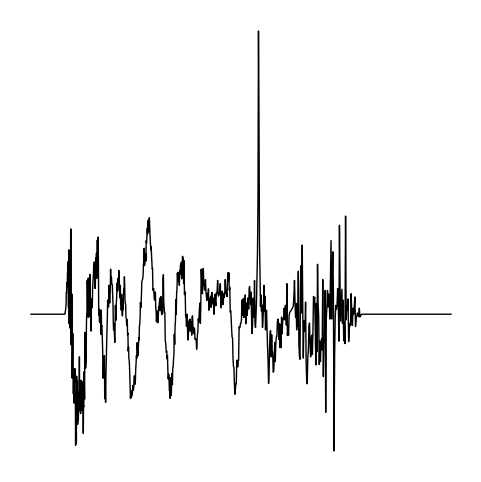

In [58]:
my_dpi = 100
fig, ax = plt.subplots(figsize=(6,6), dpi=my_dpi)
ax.plot(wavelength, main_wavelenght_t.iloc[:, 2500], lw=1.0, ls='-', color='k', alpha=1)
ax.axis('off')
ax.set_box_aspect(1)
#ax.set_xlim(2500, 10000)
#ax.set_ylim(0,1)
plt.show()